# **Group Project: Real or Not? NLP with Disaster Tweets**

![Banner](https://drive.google.com/uc?id=1MsbQD_6h73BTvQ7j8dJCpcs-LwjYk0kr)

## 🔗 **[Github Repo](https://github.com/mbayle98/DMML2020-Alpina)**

## 🕵️ **Project Description**

Twitter has become a popular social network for many users. However, it is also used to relay fake news.  

The goal of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one’s are not.  

To train the model, we have access to a dataset of 6,471 tweets that were already classified (0 = fake news tweets, 1 = real news tweets).

## 📦 **Import Required Libraries**

In [ ]:
# Notebook containg preprocessing functions
import re 
!curl -O https://raw.githubusercontent.com/mbayle98/DMML2020-Alpina/main/Code/Alpina_Preprocessing.ipynb
%run Alpina_Preprocessing.ipynb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8885  100  8885    0     0  43553      0 --:--:-- --:--:-- --:--:-- 43553


In [ ]:
# Install nltk and geograpy3
!pip install nltk
!pip install geograpy3

In [ ]:
# Basic libraries
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns

In [ ]:
# nltk library
import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
# sklearn library
import sklearn
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
LE = LabelEncoder()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score

In [ ]:
# Various libraries
from wordcloud import WordCloud
import spacy
sp = spacy.load('en_core_web_sm')
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS as stpw
import string
pct = string.punctuation
import geograpy

In [ ]:
# Config stuff
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
sns.set_style('white')
np.random.seed = 72

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 📂 **Load Data**

#### **Train Data**

In [ ]:
# Import train data
df = pd.read_csv("https://raw.githubusercontent.com/mbayle98/DMML2020-Alpina/main/Data/training_data.csv")
df.head(10)

id  ... target
0   3738  ...      0
1    853  ...      0
2  10540  ...      1
3   5988  ...      1
4   6328  ...      1
5   6669  ...      1
6   9772  ...      0
7  10361  ...      0
8   1953  ...      0
9   9586  ...      1

[10 rows x 5 columns]

In [ ]:
print("There are " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns in the dataset.")

There are 6471 rows and 5 columns in the dataset.


#### **Test Data**

In [ ]:
# Import test data
df_test = pd.read_csv("https://raw.githubusercontent.com/mbayle98/DMML2020-Alpina/main/Data/%20test_data.csv")
df_test.head(10)

id  ...                                               text
0   9972  ...  Crptotech tsunami and banks.\n http://t.co/KHz...
1   9865  ...  I'm that traumatised that I can't even spell p...
2   1937  ...  @foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3   3560  ...  Me watching Law &amp; Order (IB: @sauldale305)...
4   2731  ...                  Papi absolutely crushed that ball
5  10020  ...  Brain twister let drop up telly structuring ca...
6   8676  ...  RT twit_san_diego 'Possible sinkhole disrupts ...
7   3131  ...  Aircraft debris found on island is from MH370 ...
8   2195  ...  'Kessler Syndrome' is the name for the catastr...
9   3484  ...  So a train derailed and instead of me getting ...

[10 rows x 4 columns]

## 📐 **Base Rate**
Base rate calculated on the original train set (unmodified)

In [ ]:
base_rate = max(df.value_counts('target'))/df.shape[0]
print('Base rate:', round(base_rate,2))

Base rate: 0.57


The base rate of 0.57 means that without any further improvement of the algorithm than simply label all the tweets as being fake news (```target = 0```), this algorithm would have an accuracy of 57% on the train data.


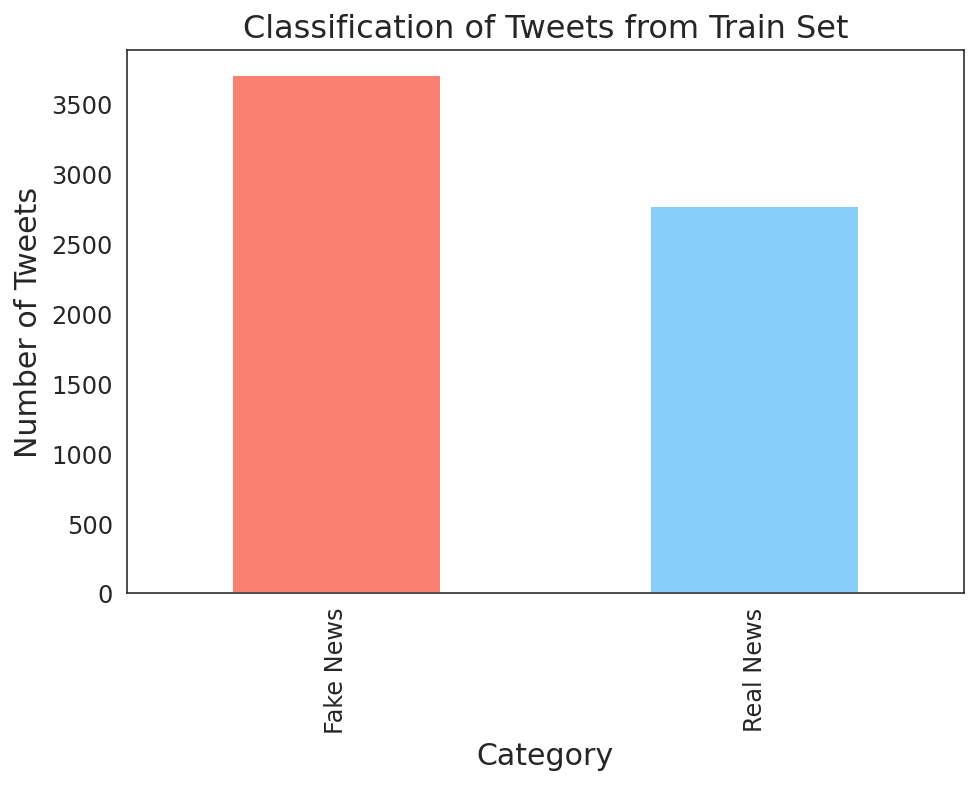

In [ ]:
ax = df['target'].value_counts().plot(kind = 'bar', figsize = (7.5,5), color = ('salmon', 'lightskyblue'))
ax.set_title('Classification of Tweets from Train Set', size = 16)
ax.set_xlabel('Category', size = 15)
ax.set_ylabel('Number of Tweets', size = 15)
ax.set_xticklabels(['Fake News', 'Real News'], size = 12)
ax.set_yticklabels(range(0,4000,500), size = 12)
plt.rcParams['font.family'] = 'sans-serif'
plt.show()

In [ ]:
print('Number of Tweets by category')
print('Fake news:', df.value_counts('target')[0], '(', round(df.value_counts('target')[0]/sum(df.value_counts('target')), 2), ')')
print('Real news:', df.value_counts('target')[1], '(', round(df.value_counts('target')[1]/sum(df.value_counts('target')), 2), ')')

Number of Tweets by category
Fake news: 3701 ( 0.57 )
Real news: 2770 ( 0.43 )


Given that the distribution of the two classes is not too far from 50%, this means that our dataset is quite balanced and that we don't have to deal with imbalanced classes.

## 📊 **EDA**
Visualization performed on the original train set (unmodified)

### 💬 **Keywords**

#### 📁 **All Data**

##### ⚙️ ***Code of the plot***


In [ ]:
df_keyword = df['keyword'].value_counts()
df_keyword_top_50 = df_keyword[0:50]

In [ ]:
df_keyword_top_50

deluge                 39
earthquake             38
harm                   37
collision              37
ambulance              36
siren                  36
sinking                36
hostages               36
collided               36
fatalities             36
crush                  35
destroy                35
fear                   35
weapons                35
outbreak               35
twister                35
wreckage               34
flames                 34
sinkhole               34
armageddon             34
sunk                   34
fatal                  34
burning%20buildings    34
body%20bags            34
damage                 33
massacre               33
ablaze                 33
hijacker               33
flooding               33
hellfire               33
catastrophe            33
death                  33
blaze                  33
derailment             33
fire                   33
weapon                 33
wreck                  32
devastation            32
derail      

##### 📊 ***Top 50 Keywords from Train Data***

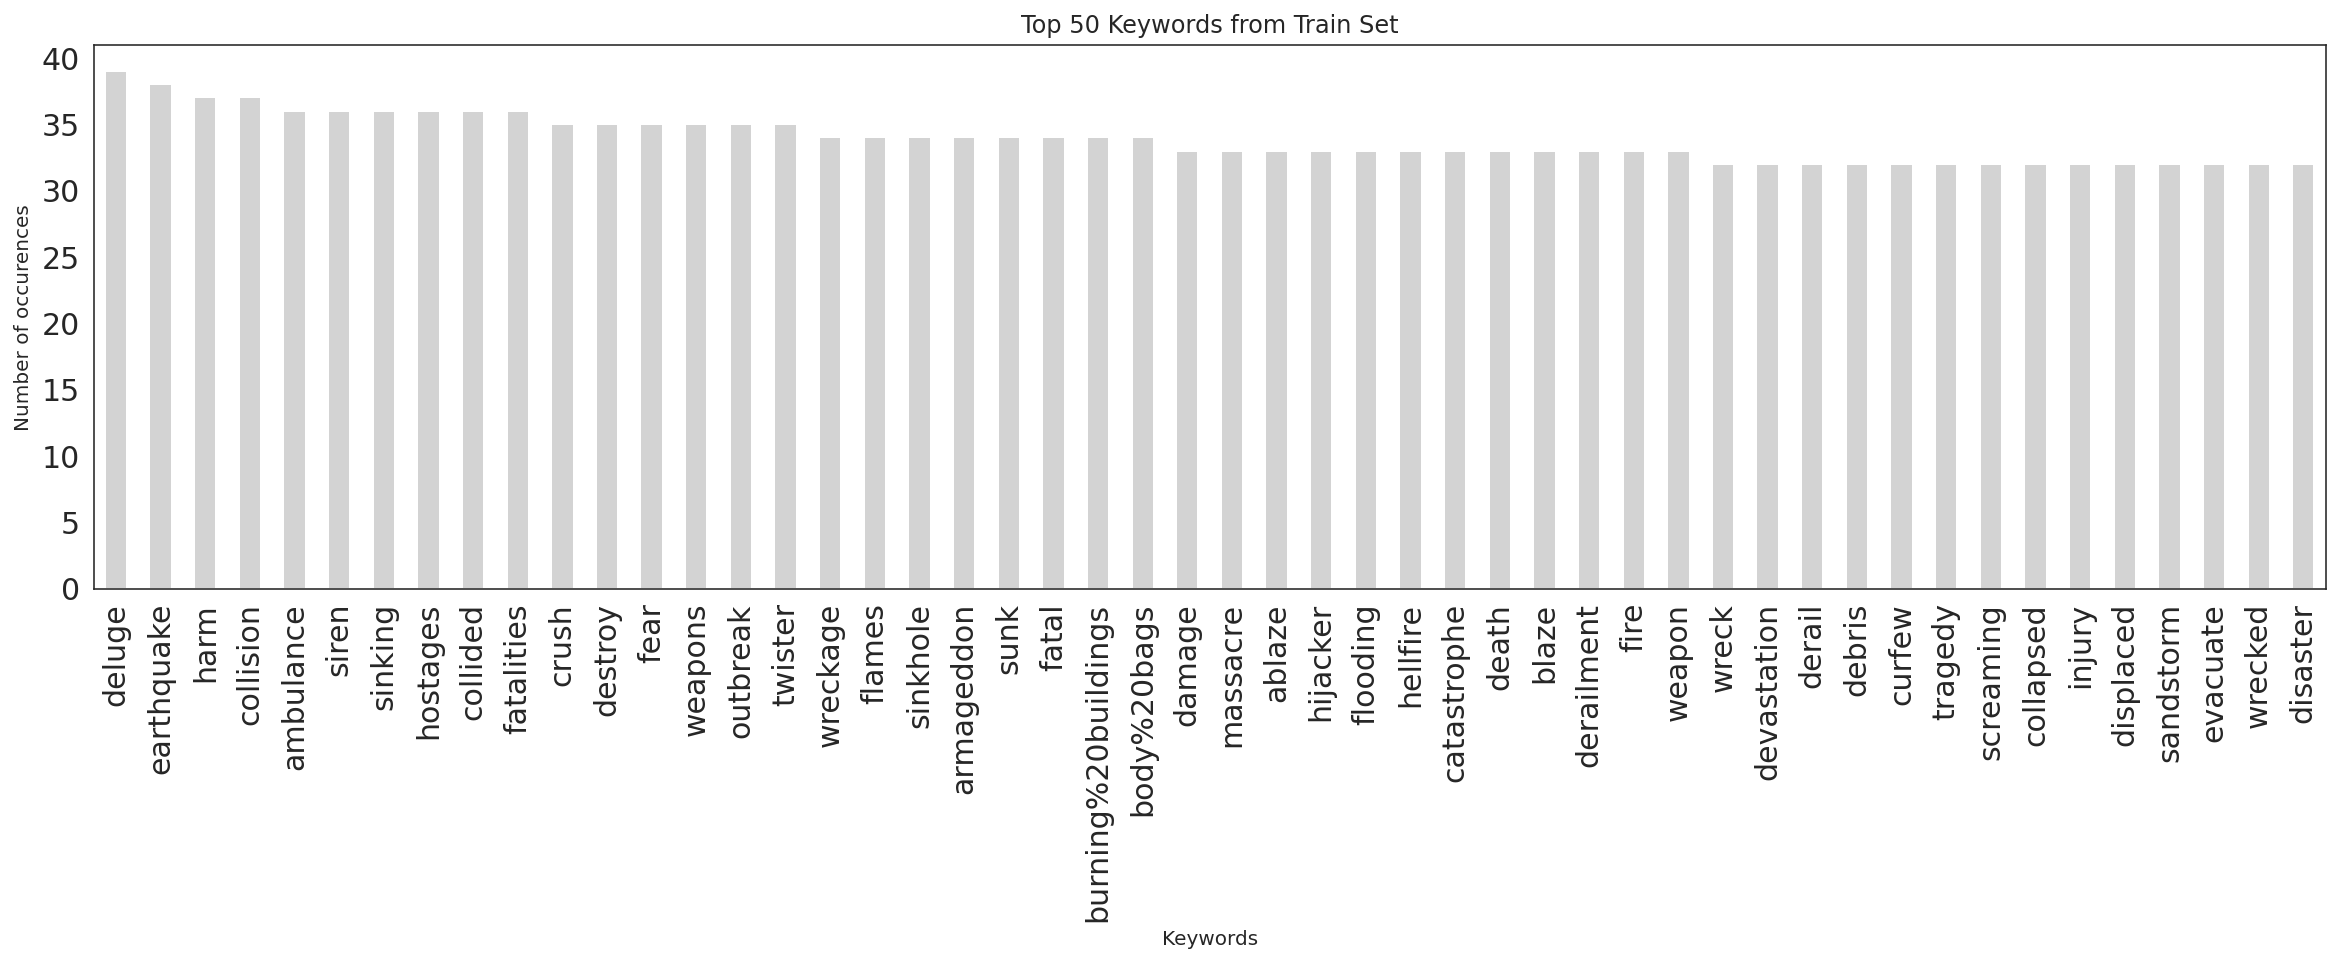

In [ ]:
df_keyword_top_50.plot.bar(xlabel = 'Keywords', ylabel = 'Number of occurences', title = 'Top 50 Keywords from Train Set', legend = False, grid = False, figsize=(20, 5), color = 'lightgrey', fontsize = 15)

#### ❌ **Fake News Tweets**

##### ⚙️ ***Code of the plot***

In [ ]:
df_keyword_fake = df['keyword'].loc[(df['target'] == 0)].value_counts()
df_keyword_fake_top_50 = df_keyword_fake[0:50]

In [ ]:
df_keyword_fake_top_50

body%20bags    33
deluge         33
harm           33
aftershock     32
armageddon     31
siren          31
crush          31
fear           31
twister        31
screaming      30
ruin           29
smoke          29
sinking        29
wrecked        29
blaze          29
body%20bag     28
panic          28
stretcher      28
blazing        28
blight         27
inundated      27
catastrophe    27
blizzard       27
army           27
curfew         27
electrocute    27
mayhem         26
quarantine     26
traumatised    26
explode        26
screamed       26
blew%20up      26
trouble        26
destroy        26
panicking      26
screams        26
upheaval       26
collide        26
hellfire       26
sunk           26
obliterated    25
blood          25
lava           25
bloody         25
drown          25
bleeding       25
wreck          25
blown%20up     25
detonate       25
death          24
Name: keyword, dtype: int64

##### 📊 ***Top 50 Keywords in Fake Tweets from Train Data***

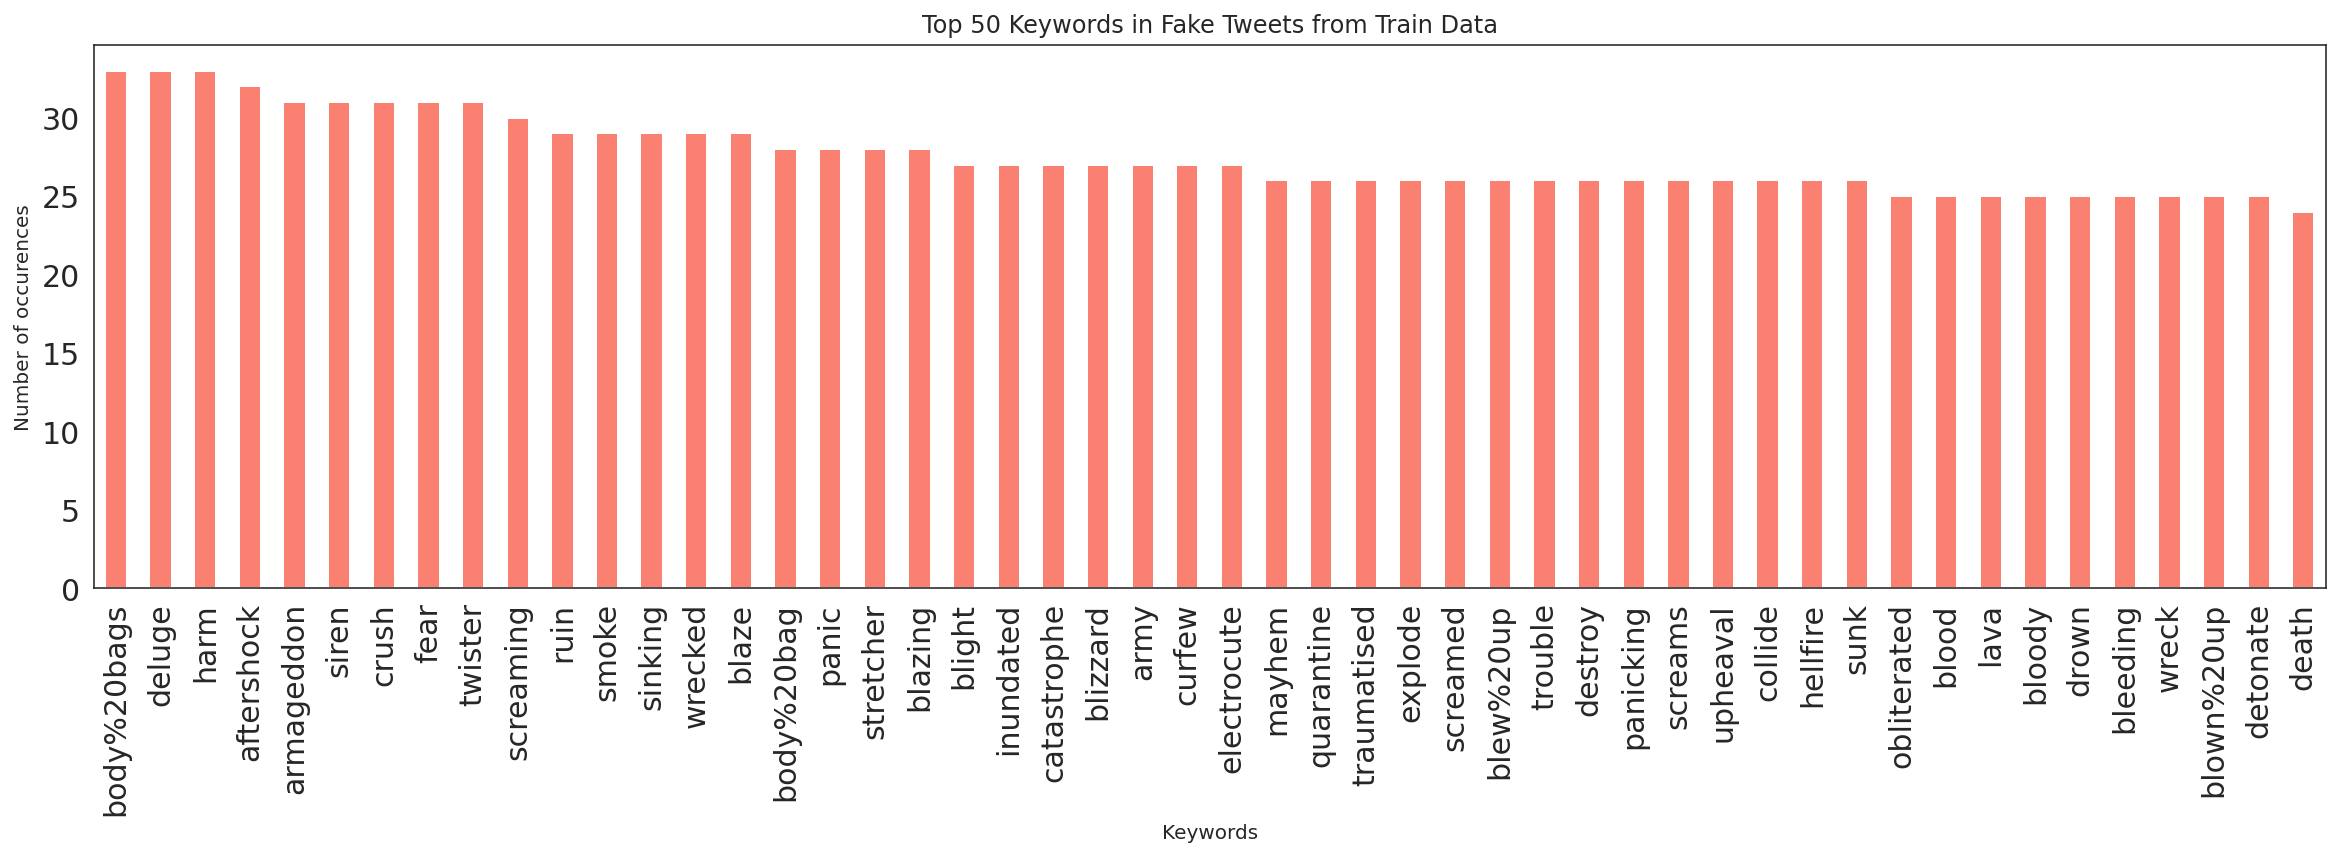

In [ ]:
df_keyword_fake_top_50.plot.bar(xlabel = 'Keywords', ylabel = 'Number of occurences', title = 'Top 50 Keywords in Fake Tweets from Train Data', legend = False, grid = False, figsize=(20, 5), color = 'salmon', fontsize = 15)

The key words in fake news tweets are mainly rather imprecise negative words (such as prejudice, fear, panic, etc.) but also words describing an apocalyptic end of the world (deluge, armageddon, hellfire, etc.).

#### ✔️ **Real News Tweets**

##### ⚙️ ***Code of the plot***

In [ ]:
df_keyword_real = df['keyword'].loc[(df['target'] == 1)].value_counts()
df_keyword_real_top_50 = df_keyword_real[0:50]

In [ ]:
df_keyword_real_top_50

outbreak                 35
wreckage                 34
derailment               33
debris                   32
typhoon                  32
oil%20spill              30
earthquake               29
razed                    28
nuclear%20disaster       28
rescuers                 27
collision                27
suicide%20bomber         27
airplane%20accident      26
wildfire                 26
suicide%20bombing        26
hostages                 26
suicide%20bomb           26
evacuation               25
devastation              25
bombing                  25
evacuated                25
buildings%20on%20fire    25
sandstorm                24
drought                  24
sinkhole                 23
hailstorm                23
massacre                 23
heat%20wave              23
displaced                23
casualties               22
wild%20fires             22
flooding                 22
deaths                   22
bridge%20collapse        22
fatal                    22
forest%20fires      

##### 📊 ***Top 50 Keywords in Real Tweets from Train Data***

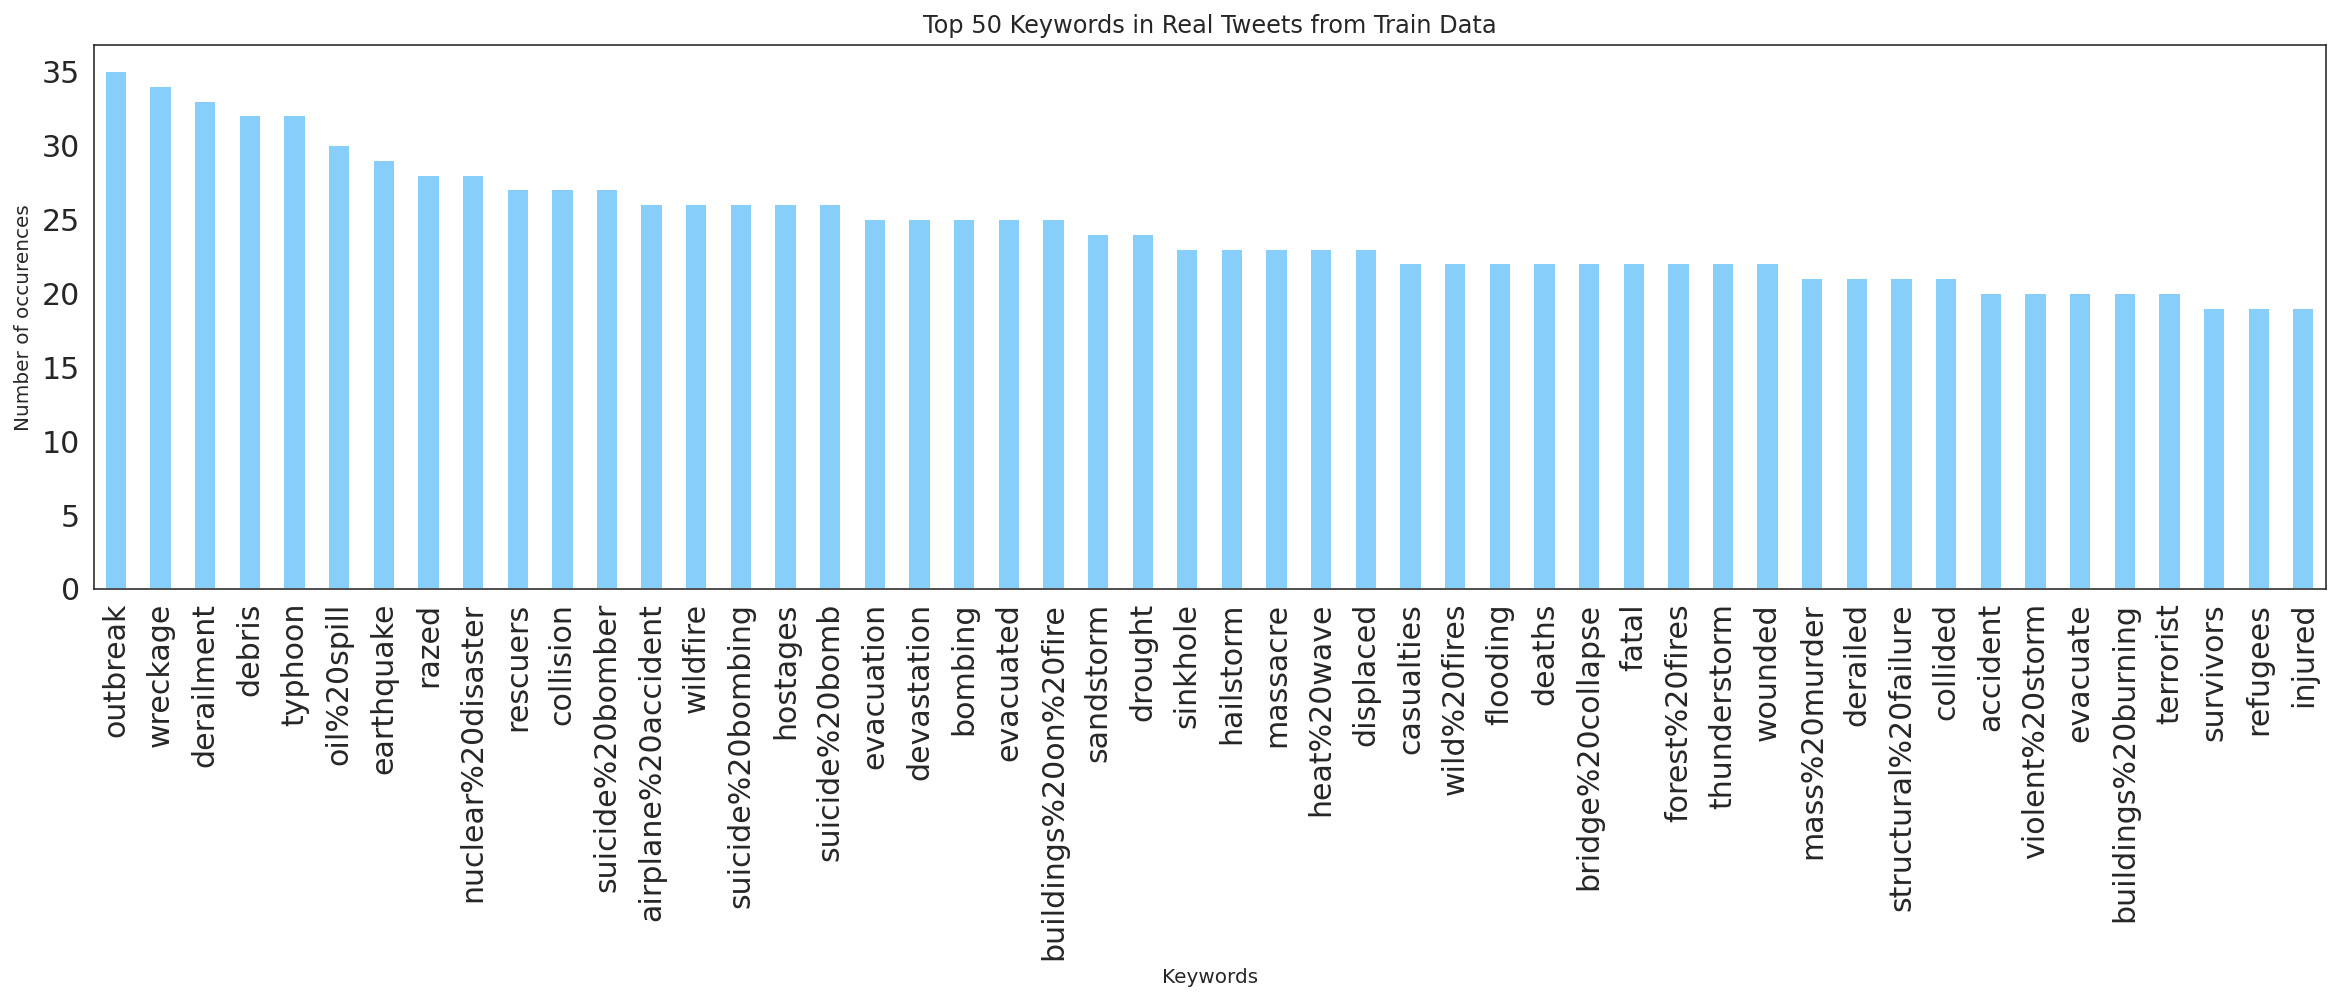

In [ ]:
df_keyword_real_top_50.plot.bar(xlabel = 'Keywords', ylabel = 'Number of occurences', title = 'Top 50 Keywords in Real Tweets from Train Data', legend = False, grid = False, figsize=(20, 5), color = 'lightskyblue',fontsize = 15)

We can see that the keywords in the actual tweets mainly concern natural disasters (such as a pandemic, typhoon, earthquake, etc.), accidents (derailment, collision, wreckage, etc.) and attacks (hostages, bomb, death, etc.).

### 📍 **Locations**

#### 📁 **All Data**

##### ⚙️ ***Code of the plot***

In [ ]:
df_location = df['location'].value_counts()
df_location_top_50 = df_location[0:50]

In [ ]:
df_location_top_50

USA                  91
New York             59
United States        46
London               39
Canada               25
UK                   24
Los Angeles, CA      23
Nigeria              22
India                21
Washington, DC       20
Mumbai               20
Australia            17
Kenya                16
Chicago, IL          15
Everywhere           14
California           14
Worldwide            14
New York, NY         13
Florida              13
United Kingdom       13
Washington, D.C.     13
California, USA      12
NYC                  12
San Francisco        12
Los Angeles          11
Indonesia            10
Toronto              10
Sacramento, CA       10
Texas                10
San Francisco, CA    10
ss                    9
Seattle               9
304                   9
Earth                 9
Manchester            9
Dallas, TX            8
Denver, Colorado      8
New York City         8
London, England       8
Ireland               8
US                    8
London, UK      

##### 📊 ***Top 50 Locations from Train Data***

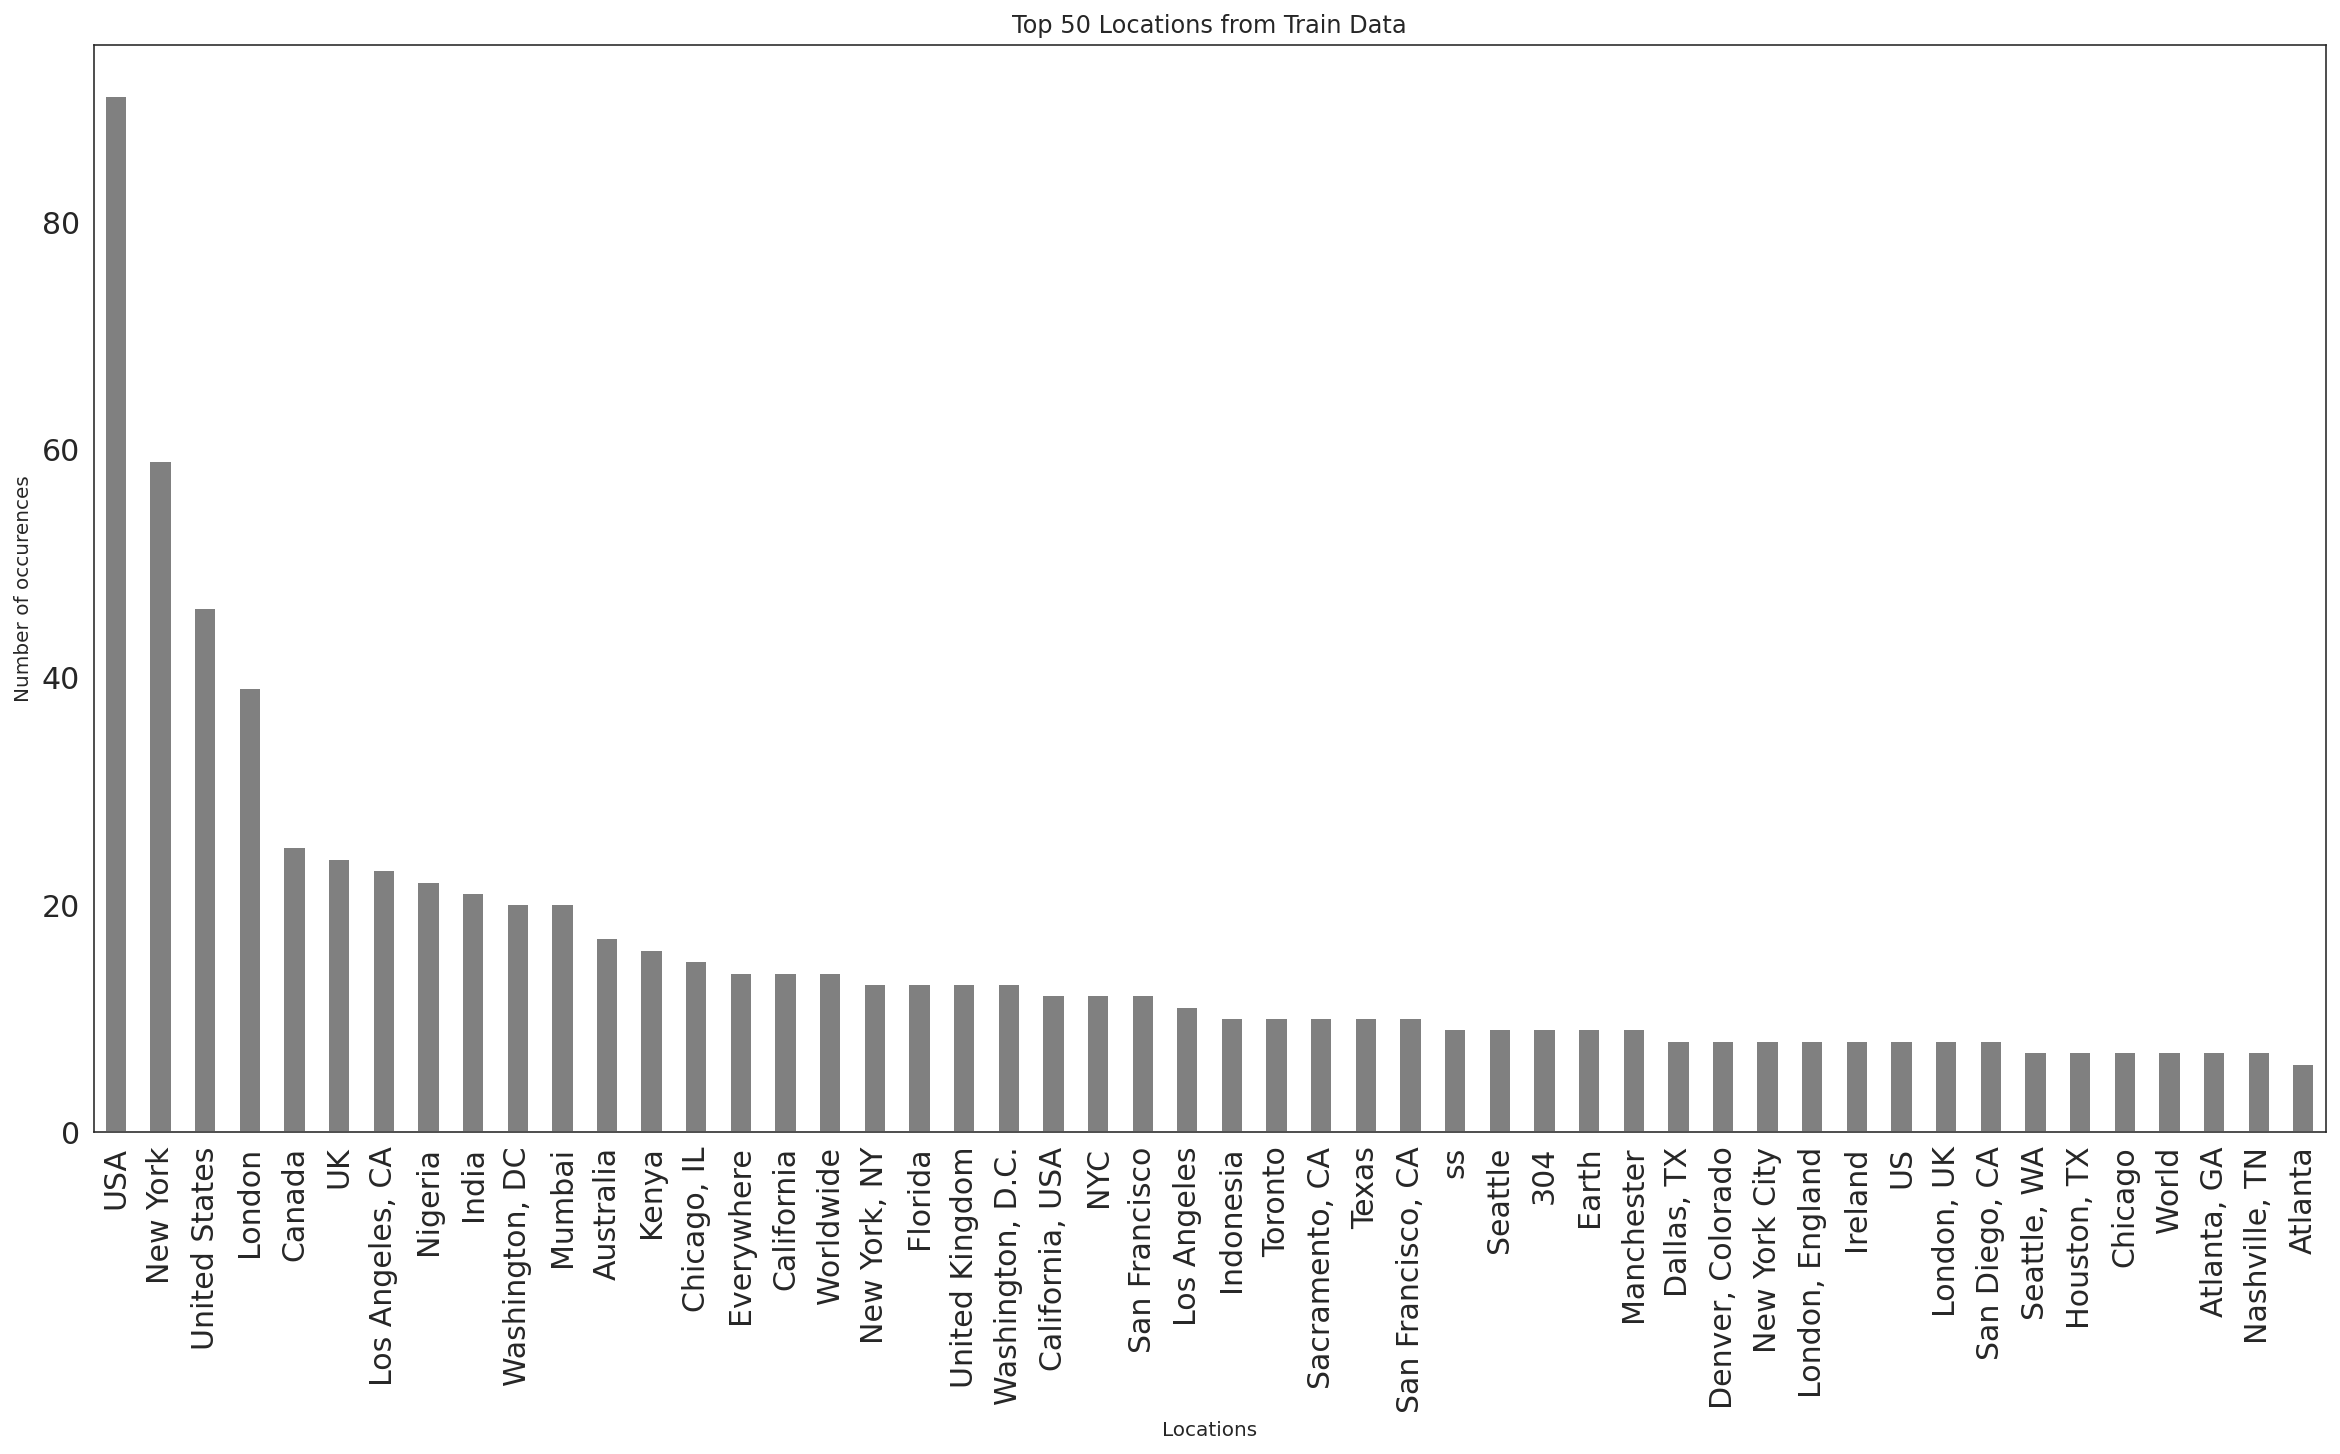

In [ ]:
df_location_top_50.plot.bar(xlabel = 'Locations', ylabel = 'Number of occurences', title = 'Top 50 Locations from Train Data', legend = False, grid = False, figsize=(20, 10), color = 'grey',fontsize = 15)

#### ❌ **Fake News Tweets**

##### ⚙️ ***Code of the plot***

In [ ]:
df_location_fake = df['location'].loc[(df['target'] == 0)].value_counts()
df_location_fake_top_50 = df_location_fake[0:50]

In [ ]:
df_location_fake_top_50

New York                     47
USA                          33
London                       25
United States                21
Los Angeles, CA              16
Canada                       14
Kenya                        12
Everywhere                   11
UK                           11
NYC                          10
United Kingdom               10
Florida                      10
Australia                     9
304                           9
London, England               8
ss                            8
California                    8
San Francisco                 7
Chicago, IL                   7
Texas                         7
Manchester                    7
Seattle                       6
Morioh, Japan                 6
San Diego, CA                 6
New York, NY                  6
Pennsylvania, USA             6
Washington, DC                6
Los Angeles                   6
Worldwide                     6
California, USA               6
Brooklyn, NY                  5
Dallas, 

##### 📊 ***Top 50 Locations in Fake Tweets from Train Data***

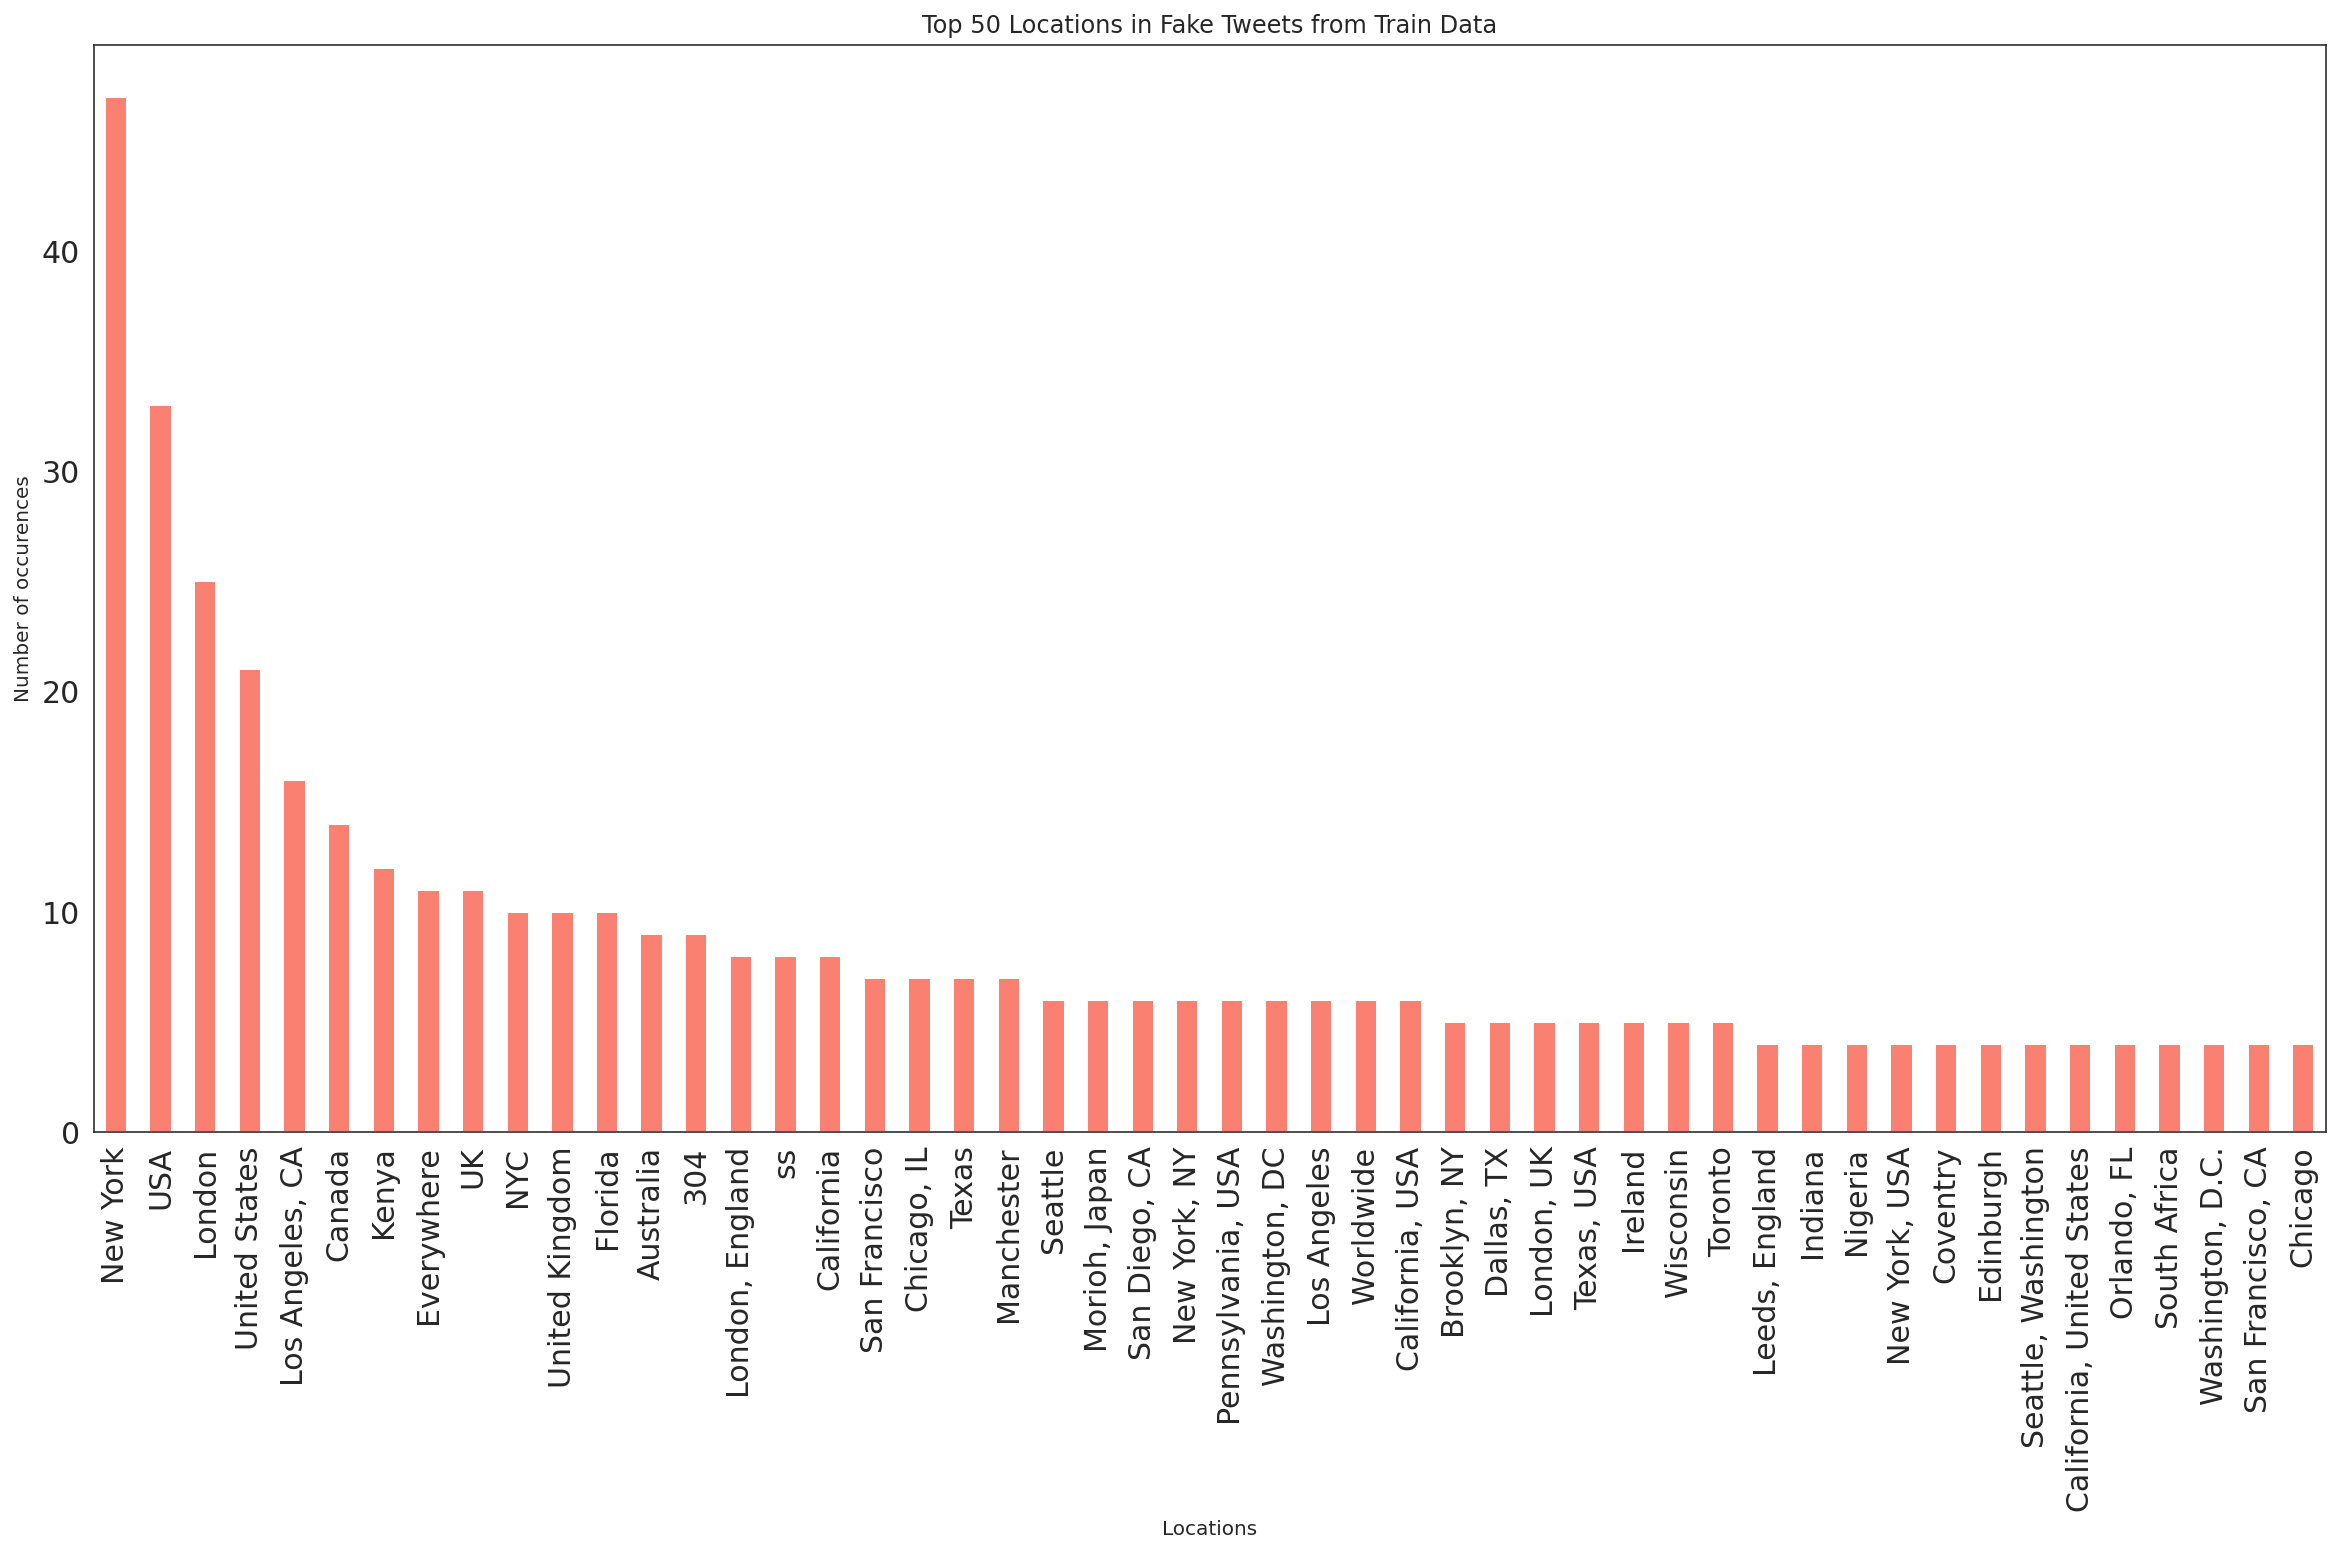

In [ ]:
df_location_fake_top_50.plot.bar(xlabel = 'Locations', ylabel = 'Number of occurences', title = 'Top 50 Locations in Fake Tweets from Train Data', legend = False, grid = False, figsize=(20, 10), color = 'salmon',fontsize = 15)

A significant number of the fake tweets come from the western world with mainly different locations in the United States, United Kingdom, Canada, Australia but also Kenya.

#### ✔️ **Real News Tweets**

##### ⚙️ ***Code of the plot***

In [ ]:
df_location_real = df['location'].loc[(df['target'] == 1)].value_counts()
df_location_real_top_50 = df_location_real[0:50]

In [ ]:
df_location_real_top_50

USA                         58
United States               25
India                       18
Nigeria                     18
Mumbai                      17
London                      14
Washington, DC              14
UK                          13
New York                    12
Canada                      11
Washington, D.C.             9
Australia                    8
Worldwide                    8
Chicago, IL                  8
Los Angeles, CA              7
New York, NY                 7
Earth                        7
Sacramento, CA               7
Indonesia                    6
San Francisco, CA            6
California, USA              6
Denver, Colorado             6
California                   6
US                           5
Nashville, TN                5
Toronto                      5
Los Angeles                  5
San Francisco                5
Oklahoma City, OK            5
New York City                5
Kenya                        4
Pedophile hunting ground     4
Bend, Or

##### 📊 ***Top 50 Locations in Real Tweets from Train Data***

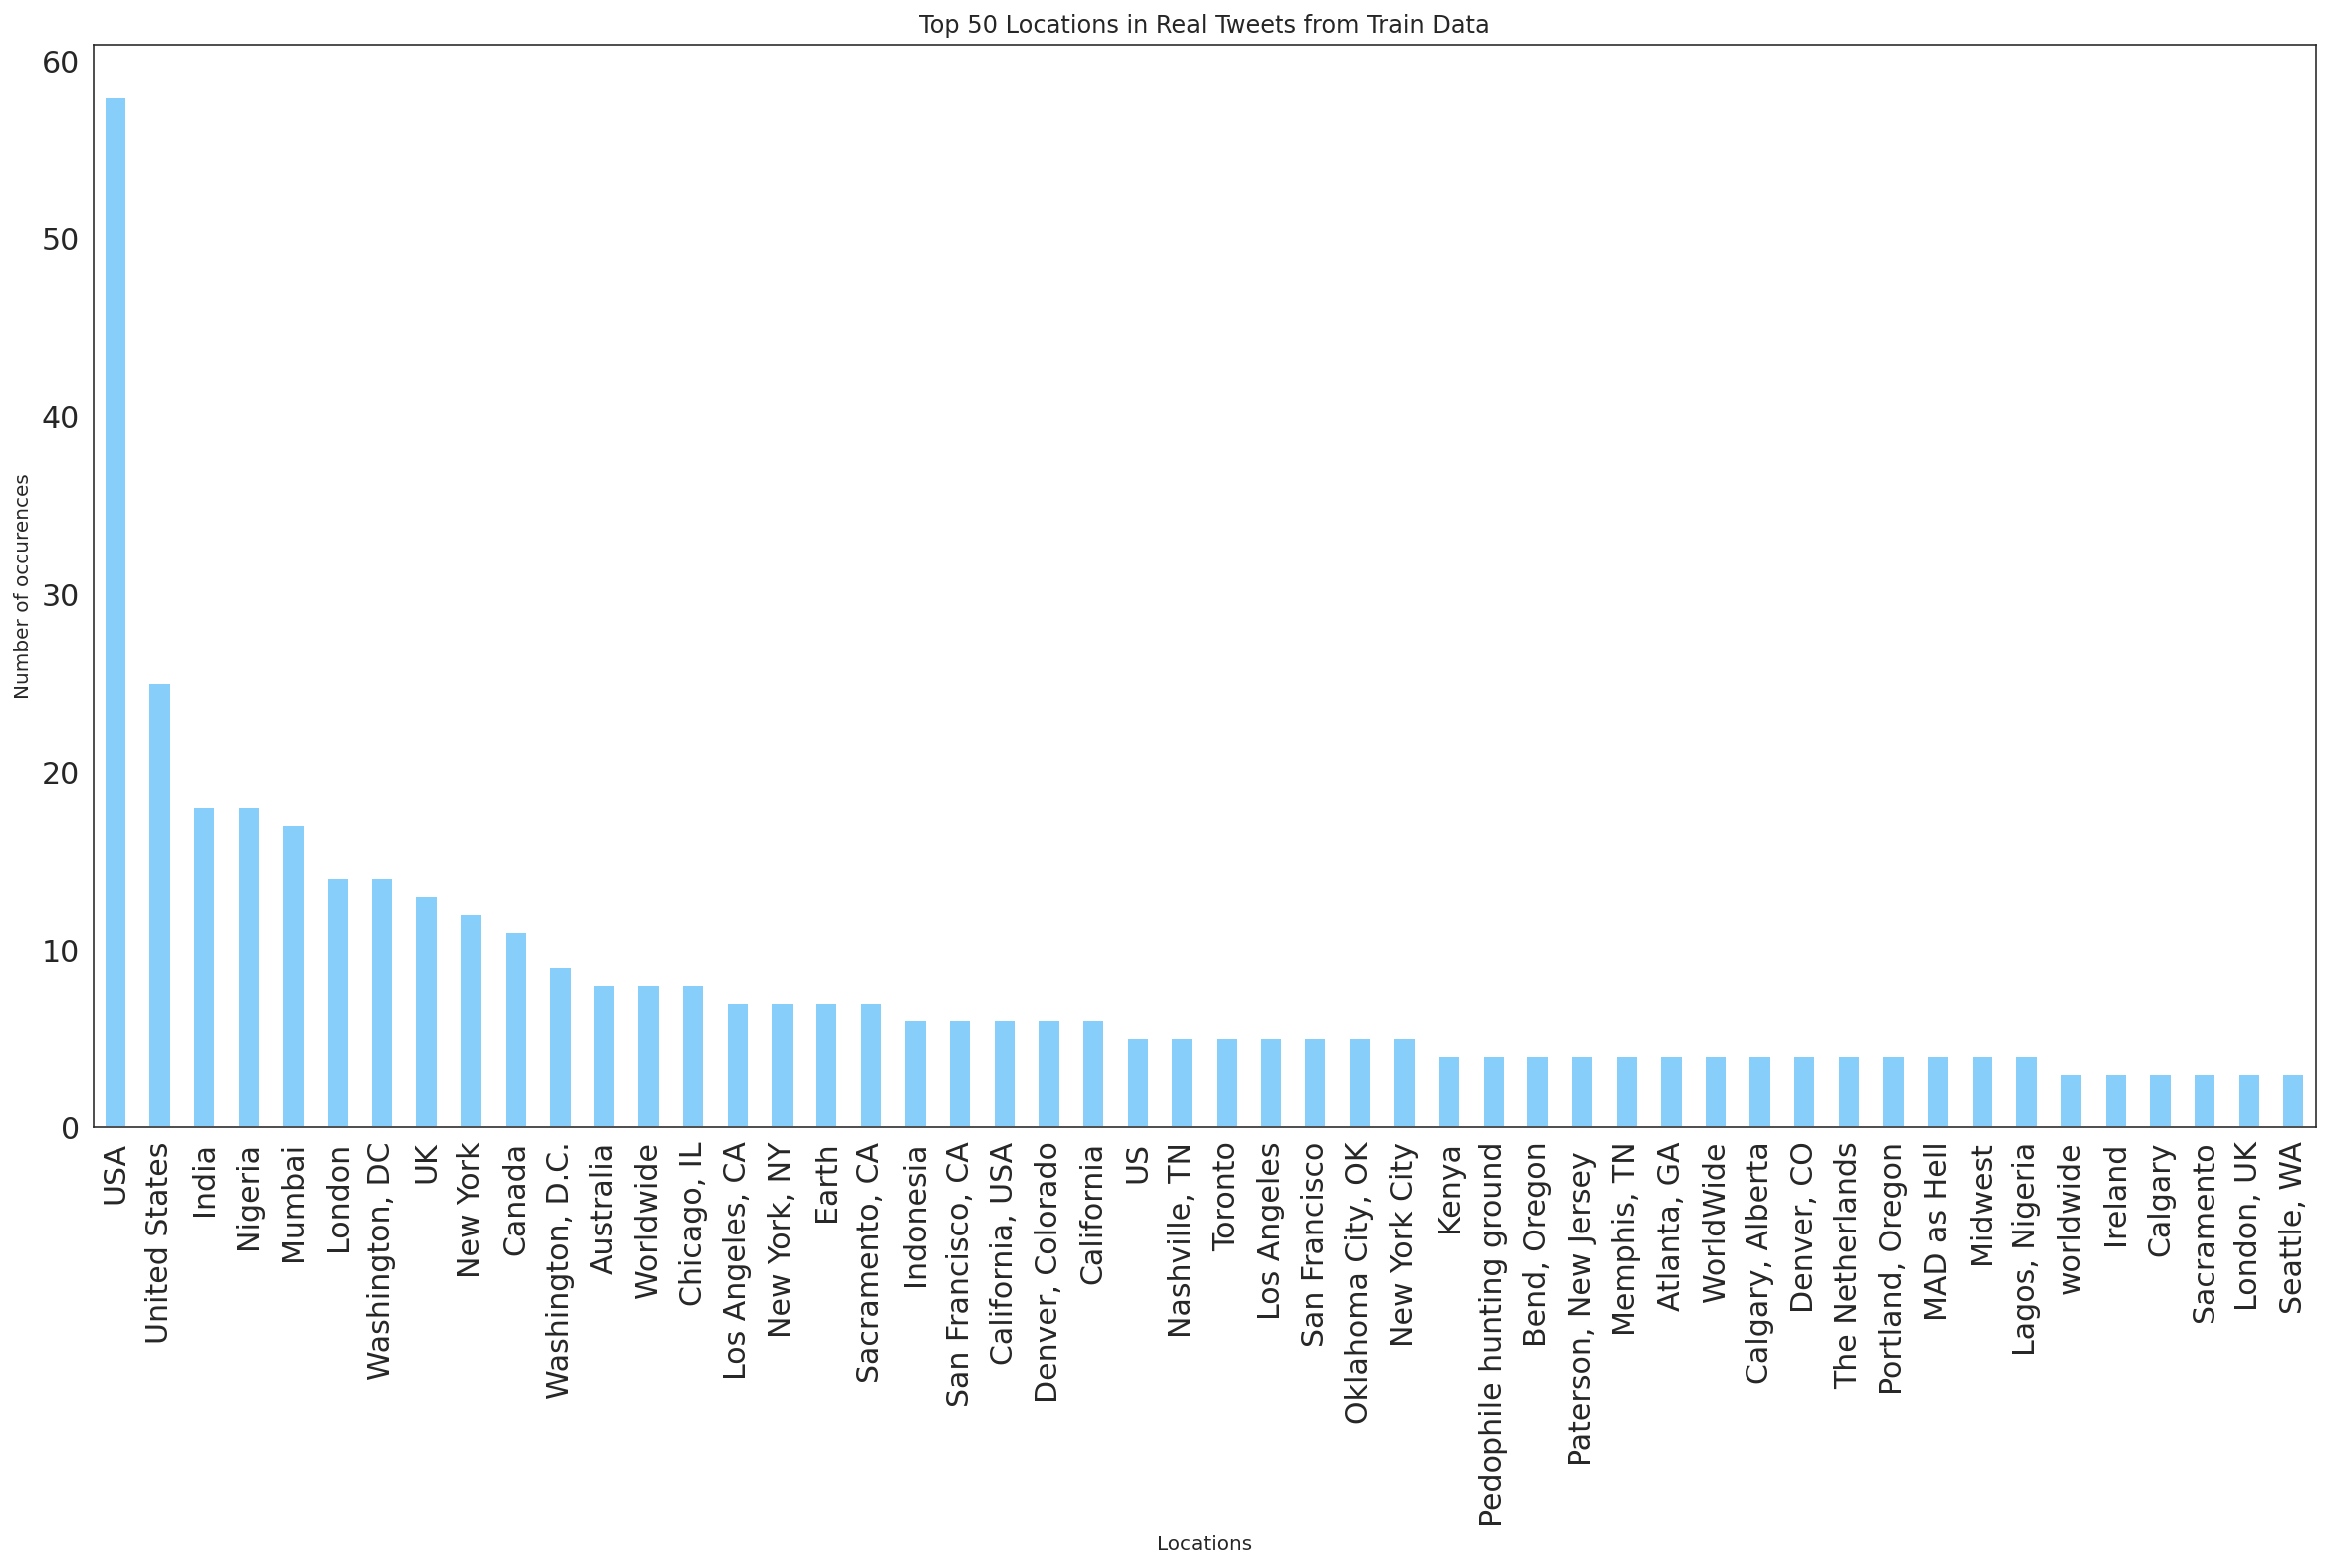

In [ ]:
df_location_real_top_50.plot.bar(xlabel = 'Locations', ylabel = 'Number of occurences', title = 'Top 50 Locations in Real Tweets from Train Data', legend = False, grid = False, figsize=(20, 10), color = 'lightskyblue',fontsize = 15)

Although we saw earlier that a large number of fake news tweets come from countries such as the United States or the United Kingdom, an equally large number of real news tweets also come from those same countries. The main countries that did not previously appear are India, Nigeria and Indonesia.

### 📚 **Word Frequency**

##### ⚙️ ***Code of the plot***

In [ ]:
def wordcloud_plot(tweet, column_tweet):
    words = ' '.join([tweet for tweet in tweet[column_tweet]])
    # Display the generated image
    wordcloud = WordCloud().generate(words)
    # Lower max_font_size
    plt.figure(figsize=(15,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

##### ❌ ***Most Common Word in Fake News Tweets***

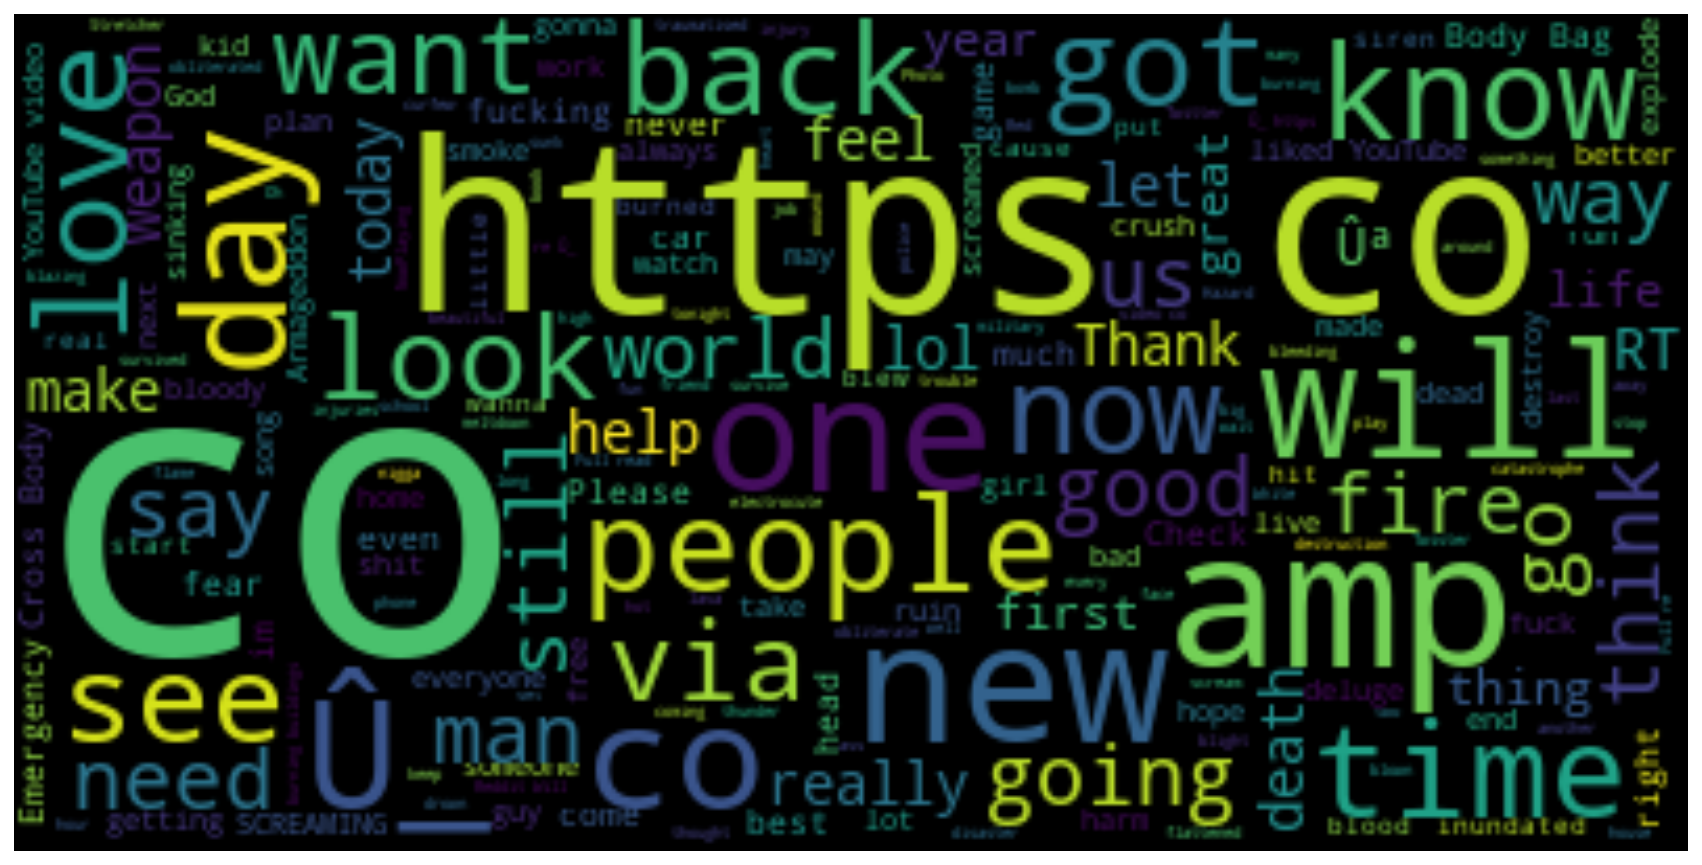

In [ ]:
wordcloud_plot(df[df['target'] == 0], 'text')

Although the data needs to be cleaned up, we already notice a significant presence of verbs compared to other types of words. For example, there are verbs such as *know*, *see*, *want*, *go*, *will*, *think*, *need*, *look*, etc.

##### ✔️ ***Most Common Word in Real News Tweets***

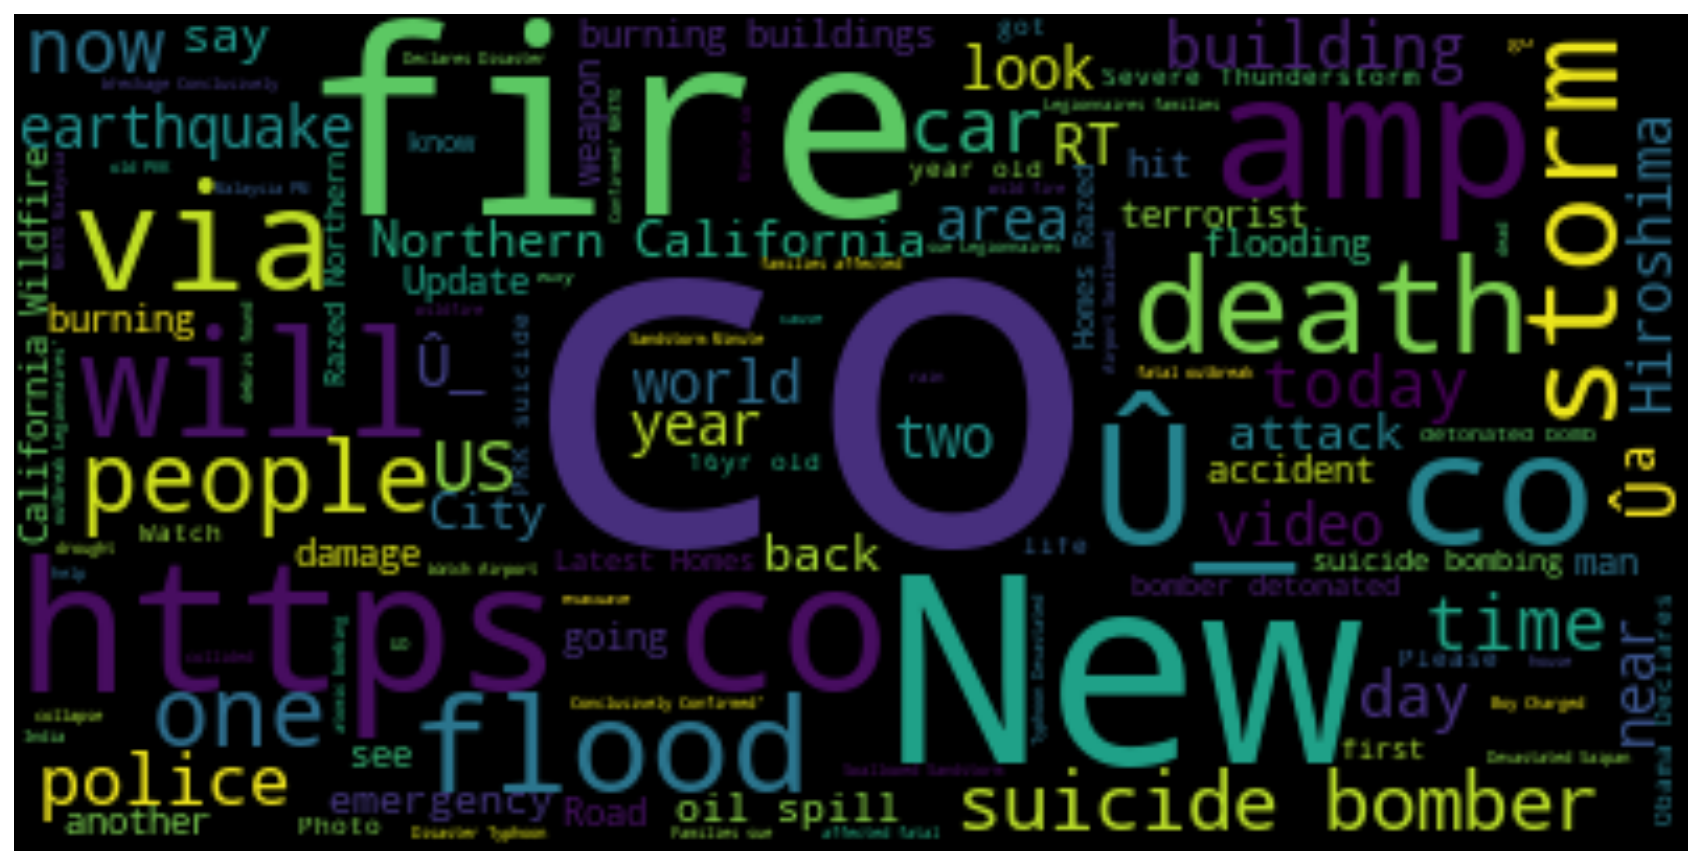

In [ ]:
wordcloud_plot(df[df['target'] == 1], 'text')

As far as real news tweets are concerned, we note that the contrast is important as they seem to have a tendency to use words describing certain facts, such as *fire*, *flood*, *death*, *storm*, *suicide bomber*, *police*, etc.

## 🧹 **Data Cleaning and more ...**

**Our Approach**
- Try cleaning functions one by one and testing the accuracy and see if it increased the accuracy

- Finally, we ended up with the functions below → When combined, these functions give us the best accuracies

In [ ]:
# Create a new empty dataframe
df_clean = pd.DataFrame()

### **Tweets**

In [ ]:
# Convert each tweet into string
df_clean['text'] = df['text'].apply(lambda x: str(x))

# Lowercase
df_clean['text'] = df_clean['text'].apply(lambda x: x.lower())

# Delete URLs
df_clean['text'] = df_clean['text'].apply(lambda x: bin_http(x))

# Expand contractions
df_clean['text'] = df_clean['text'].apply(lambda x: expand_contractions(x))

# Delete usernames
df_clean['text'] = df_clean['text'].apply(lambda x: bin_username(x))

# Remove special caracters and numbers
df_clean['text'] = df_clean['text'].apply(lambda x: bin_spe(x))

# Remove punctuation
df_clean['text'] = df_clean['text'].apply(lambda x: punctuation_removal(x))

# Creation of df with only the upper fonction applied
df_wordcount = df_clean.copy()

# Remove stopwords
df_clean['text'] = df_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stpw]))

# Lemmatizer
df_clean['text'] = df_clean['text'].apply(lambda x: lemmatizer(x))

# Remove alone letters 
df_clean['text'] = df_clean['text'].apply(lambda x: remove_alone_letters(x))

**Our approach**

- Search for **elements that would allow us to identify fake news in the language**
→ Before doing any code, we searched for literature about this topic

- We found one article : Horne, B. D., & Adali, S. (2017). [This just in: Fake news packs a lot in title, uses simpler, repetitive content in text body, more similar to satire than real news](https://www.researchgate.net/profile/Benjamin_Horne2/publication/315682536_This_Just_In_Fake_News_Packs_a_Lot_in_Title_Uses_Simpler_Repetitive_Content_in_Text_Body_More_Similar_to_Satire_than_Real_News/links/58de4973a6fdcc3c6ac35529/This-Just-In-Fake-News-Packs-a-Lot-in-Title-Uses-Simpler-Repetitive-Content-in-Text-Body-More-Similar-to-Satire-than-Real-News.pdf). *arXiv preprint arXiv:1703.09398*.

- The **main question**: "*Is there any systematic stylistic and other content differences between fake and real news?*"

- The **conclusion** of the article: "(...) fake news use **fewer stopwords** and **nouns** but use **more proper nouns** and **verb phrases**"

- we decided to take an interest in the content of the sentences. We found the package **pos_tag** (*part-of-speech tagging*) which enable us to get the lexical category of a word such as *nouns*, *verbs*, *adjectives*, etc.

- More precisely, here is a tab with the **different categories** (note: we did not applied lemmatizer nor stopwords in order to get the real categories of words (*singular*, *plural*, *verb form*, etc.):


The below [table](https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/) is giving the different acrononyms of the POS_tag package:

| **Abbreviation** | **Categories**                        | **Example** |
|------------------|----------------------------------------|-------------|
| **CD**           | Cardinal digit                         |   |  
| **DT**           | Determiner                             |   |
| **EX**           | Existential there                      | "*There is" think of it like "there exists"*  |
| **FW**           | Foreign word                           |   |
| **IN**           | Preposition/subordinating conjunction  |   |
| **JJ**           | Adjective                              | *Big* |
| **JJR**          | Adjective (comparative)                | *Bigger*  |
| **JJS**          | Adjective (superlative)                | *Biggest*  |
| **LS**           | List marker                            | *1)*  |
| **MD**           | Modal could, will                      |  |
| **NN**           | Noun (singular)                        | *Desk*  |
| **NNS**          | Noun (plural)                          | *Desks*   |
| **NNP**          | Proper noun (singular)                 | *Harrison*  |
| **NNPS**         | Proper noun (plural)                   | *Americans*  |
| **PDT**          | Predeterminer                          | *All the kids*  |
| **POS**          | Possessive ending                      | *Parent's*  |
| **PRP**          | Personal pronoun                       | *I, he, she*  |
| **PRPS**         | Possessive pronoun                     | *My, his, hers*  |
| **RB**           | Adverb (very, silently)                |   |
| **RBR**          | Adverb (comparative)                   | *Better*  |
| **RBS**          | Adverb (superlative)                   | *Best*  |
| **RP**           | Particule                              | *Give up*  |
| **TO**           | To                                     | *Go to the store*  |
| **UH**           | Interjection                           | *Errrrrrrrm*  |
| **VB**           | Verb (base form)                       | *Take*  |
| **VBD**          | Verb (past tense)                      | *Took*  |
| **VBG**          | Verb (gerund/present participle)       | *Taking*  |
| **VBN**          | Verb (past participle)                 | *Taken*  |
| **VBP**          | Verb (sing. present non-3rd person)    | *Take*  |
| **VBZ**          | Verb (sing. present 3rd person)        | *Takes*  |
| **WDT**          | Wh-determiner                          | *Which*  |
| **WP**           | Wh-pronoun                             | *Who, what*  |
| **WPS**          | Possessive wh-pronoun                  | *Whose*  |
| **WRB**          | Wh-adverb                              | *Where, when*  |


         JJ        NN        DT  ...        FW      WP$       SYM
0  1.336936  3.947582  0.981627  ...  0.007836  0.00054  0.000811
1  1.455957  4.499639  0.932130  ...  0.009386  0.00000  0.000000

[2 rows x 33 columns]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

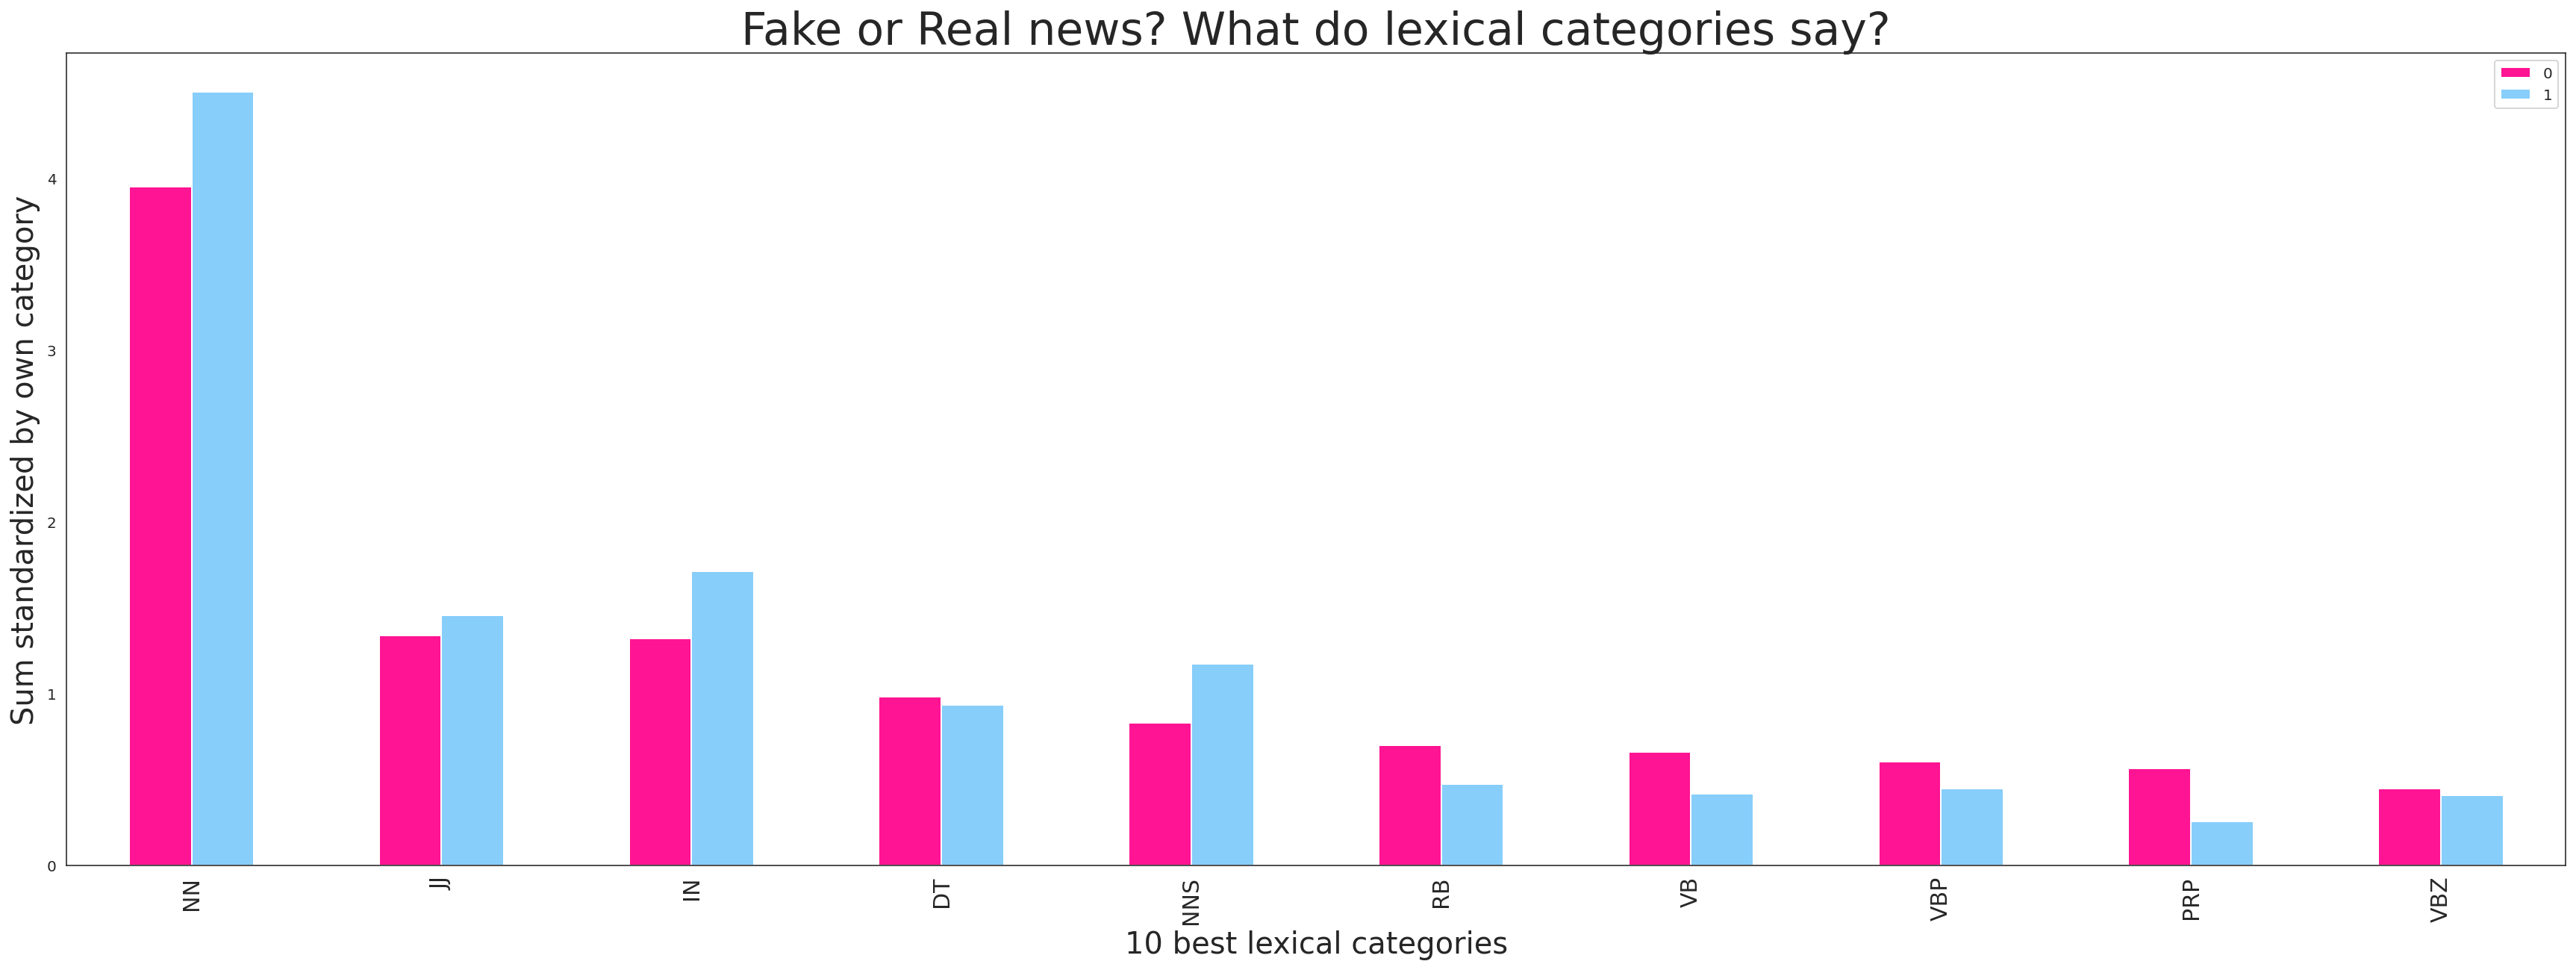

In [ ]:
from collections import Counter

def counting_by_category(tweet):                                 # Function that returns a dict{Part-of-speech: number of words contained} that composed each tweets
  token = nltk.word_tokenize(tweet.lower())                      # Tokenizer nltk package
  text = nltk.Text(token)                                        # Module Text is used to shape the data into tuples and to prepare the use of functions such as counting.
  category = nltk.pos_tag(text)                                  # Pos_tag package is used to classifify words by their lexical categories 
  counting_cat = Counter(tagging for word, tagging in category)  # Count by part-of-speech in each tweets
  return counting_cat

df_clean['text_count'] = df_wordcount['text'].apply(lambda x: counting_by_category(x)) # Apply above function on the text non lemmatized
                              
### Transformation of dict

# Transform the dict into a dataframe, such as columns are the part-of-speech and rows are each tweets
feature_wordcount = pd.DataFrame(df_clean['text_count'])
feature_wordcount = feature_wordcount['text_count'].apply(pd.Series)
feature_wordcount = feature_wordcount.fillna(0) # Fill Nan values with 0

### Creation new df to get sum of lexical categories standardized by each category of tweets (Fake/Real)

feature_wordcount['target'] = df['target']
len_fake = len(df['keyword'].loc[(df['target'] == 0)])          # Number of fake news 
len_real = len(df['keyword'].loc[(df['target'] == 1)])          # Number of real news
wordcount_cate = feature_wordcount.groupby('target').sum()      # Sum POS by category of news (real or fake)
wordcount_fake = wordcount_cate.iloc[0]/len_fake                # Standardization
wordcount_real = wordcount_cate.iloc[1]/len_real                # Standardization
wordcount_std = pd.DataFrame([wordcount_fake, wordcount_real])  # Creation new df
print(wordcount_std)

### Creation of a graph that shows for each categories of tweets each POS

wordcount_std = wordcount_std.transpose()                                 # Transpose so we have as columns (real/fake) and as rows the POS
wordcount_std = wordcount_std.sort_values(by = [0,1], ascending = False)  # Sort values by tweet category

wordcount_std.head(10).plot.bar(figsize = (30,10), color = ('deeppink', 'lightskyblue'))
plt.title('Fake or Real news? What do lexical categories say?', fontsize = 30)
plt.xlabel('10 best lexical categories', fontsize = 20)
plt.ylabel('Sum standardized by own category', fontsize = 20)
plt.xticks(fontsize = 15)


On this graph, we can see several things:

*   Fewer nouns (plural or singular) in fake news (NN and NNS)
*   More adjectives in real news (JJ)
*   More subordinating conjunctions in real news (IN)
*   A little more determiner in fake news (DT)
*   More adverb on fake news (RB)
*   More verb base form in fake news (VB)
*   More verb at present form in fake news (VBP)
*   More personal and possessive nouns in fake news (PRP)
*   More 3rd person verb in fake news (VBZ)

According to the above study, we should see in fake news:

*   ✅ Fewer nouns ;
*   ✅ More verb phrases;
*   ✅ More proper nouns.


### **Keywords**

In [ ]:
# Convert each tweet into string
df_clean['keyword'] = df['keyword'].apply(lambda x: str(x))

# Lowercase
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: x.lower())

# Delete URLs
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: bin_http(x))

# Expand contractions
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: expand_contractions(x))

# Delete usernames
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: bin_username(x))

# Remove special caracters and numbers
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: bin_spe(x))

# Remove punctuation
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: punctuation_removal(x))

# Remove stopwords
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: ' '.join([word for word in x.split() if word not in stpw]))

# Lemmatizer
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: lemmatizer(x))

# Remove alone letters 
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: remove_alone_letters(x))

# Stemming 
df_clean['keyword'] = df_clean['keyword'].apply(lambda x: ps.stem(x))

In [ ]:
#Label encoder for keyword
df_clean['keyword_label'] = pd.Series(LE.fit_transform(df_clean['keyword'])).to_frame()

### **Locations**

In [ ]:
# Convert each tweet into string
df_clean['location'] = df['location'].apply(lambda x: str(x))

# Lowercase
df_clean['location'] = df_clean['location'].apply(lambda x: x.lower())

# Delete URLs
df_clean['location'] = df_clean['location'].apply(lambda x: bin_http(x))

# Expand contractions
df_clean['location'] = df_clean['location'].apply(lambda x: expand_contractions(x))

# Delete usernames
df_clean['location'] = df_clean['location'].apply(lambda x: bin_username(x))

# Remove special caracters and numbers
df_clean['location'] = df_clean['location'].apply(lambda x: bin_spe(x))

# Remove punctuation
df_clean['location'] = df_clean['location'].apply(lambda x: punctuation_removal(x))

# Remove stopwords
df_clean['location'] = df_clean['location'].apply(lambda x: ' '.join([word for word in x.split() if word not in stpw]))

# Lemmatizer
df_clean['location'] = df_clean['location'].apply(lambda x: lemmatizer(x))

# Remove alone letters 
df_clean['location'] = df_clean['location'].apply(lambda x: remove_alone_letters(x))

In [ ]:
# Creation of a list that returns 1 if it can find a location that exists and 0 if not

df_clean['location'] = ''

for i in range(len(df['location'])):
  text = str(df['location'][i])
  places = geograpy.get_place_context(text = text)
  city = places.cities
  country = places.countries

  if len(city) != 0:
    df_clean['location'][i] = 1
  elif len(country) != 0:
    df_clean['location'][i] = 1
  else:
    df_clean['location'][i] = 0

unzipping /usr/local/lib/python3.6/dist-packages/geograpy/locs.db from /usr/local/lib/python3.6/dist-packages/geograpy/locs.db.gz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## 📈 **Logistic Regression**

In [ ]:
X = df_clean['text']

In [ ]:
y = df['target']

### A) **Logistic regression on tweets**

In [ ]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X, y, test_size = 0.1, random_state = 72)

In [ ]:
# Basic pipeline using vectorizer and a tfidf transformer, and a Logistic regression → With no hyperparameters

LogR_Ba = Pipeline([('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),('LR', LogisticRegression(max_iter = 100000))])
LogR_Ba.fit(X_trainLR, y_trainLR)
LogR_basic = LogR_Ba.score(X_testLR, y_testLR)
print('Accuracy of basic pipeline with no hyperparameter tuning: ', round(LogR_basic, 3))

pred_y_lr_basic = LogR_Ba.predict(X_testLR)
matrix_confusion_LRBASIC = confusion_matrix(y_testLR,pred_y_lr_basic)

Accuracy of basic pipeline with no hyperparameter tuning:  0.804


In [ ]:
print(LogR_Ba.get_params().keys()) # Print the parameters of each functions 

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'LR', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'LR__C', 'LR__class_weight', 'LR__dual', 'LR__fit_intercept', 'LR__intercept_scaling', 'LR__l1_ratio', 'LR__max_iter', 'LR__multi_class', 'LR__n_jobs', 'LR__penalty', 'LR__random_state', 'LR__solver', 'LR__tol', 'LR__verbose', 'LR__warm_start'])


In [ ]:
### Hyperparameters optimization with logistic regression

param_logR = {
    
    'vect__ngram_range': [(1,3), (1,2)],  # Sequence of n grams in order to predict what words comes next: best n grams with these params is (1,3)
   
    'vect__norm': ['l1', 'l2'],           # Different type of vector normalization 
   
    'LR__C': (3.8, 3.6)                   # Optimization of C started with C (1,10,100,1000) then (1,5,9) then reduced to be more and more detailed to get to 3.8 
  
    }

grid_search_logR = GridSearchCV(LogR_Ba, param_logR, cv = 5, verbose = 11) # Verbose to get the steps → Get us an idea of the time required + use of Gridsearch to find best param
grid_search_logR.fit(X_trainLR, y_trainLR)

print(grid_search_logR.best_params_) # Print the best parameters for this model

Accuracy_basic_logR = grid_search_logR.score(X_testLR, y_testLR)
print('Accuracy of pipeline with Hyper parameters tuning is: ', round(Accuracy_basic_logR, 3))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1, score=0.797, total=   1.1s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1, score=0.785, total=   0.9s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1, score=0.795, total=   1.0s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1, score=0.796, total=   0.9s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l1, score=0.807, total=   1.1s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2 ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2, score=0.797, total=   1.1s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2 ..............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.2s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2, score=0.785, total=   1.0s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.2s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2, score=0.795, total=   1.0s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.2s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2, score=0.796, total=   0.9s
[CV] LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.2s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 3), vect__norm=l2, score=0.807, total=   1.3s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1 ..............


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.5s remaining:    0.0s


[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1, score=0.797, total=   0.8s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1, score=0.785, total=   0.6s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1, score=0.795, total=   0.7s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1, score=0.797, total=   0.7s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l1, score=0.808, total=   0.7s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l2 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l2, score=0.797, total=   0.8s
[CV] LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l2 ..............
[CV]  LR__C=3.8, vect__ngram_range=(1, 2), vect__norm=l2, score=

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   35.3s finished


{'LR__C': 3.6, 'vect__ngram_range': (1, 3), 'vect__norm': 'l1'}
Accuracy of pipeline with Hyper parameters tuning is:  0.823


In [ ]:
Pred_logR = grid_search_logR.predict(X_testLR)
matrix_LR = confusion_matrix(y_testLR, Pred_logR)

### B) **Feature engineering: Location**

In [ ]:
X_location = df_clean[['location']]

In [ ]:
### Hyperparameters optimization with location

X_train_loc, X_test_loc, y_train_loc, y_test_loc= train_test_split(X_location, y, test_size = 0.1, random_state = 72)
LogR_std_location = Pipeline([('scaler', scaler),('LR', LogisticRegression(max_iter = 50000))]) # Standardization (mean 0 std 1)
LogR_std_location.get_params().keys() # Get params

param_logR_location = {
   
    'LR__C': (1, 1.25, 1.5, 1.10),
   
    'LR__max_iter': (10000, 50000),
   
    }

grid_search_logR_location = GridSearchCV(LogR_std_location, param_logR_location, cv = 5, verbose = 11)
grid_search_logR_location.fit(X_train_loc, y_train_loc)
print(grid_search_logR_location.best_params_)

Accuracy_basic_logR_location = grid_search_logR_location.score(X_test_loc, y_test_loc)
print('Accuracy of pipeline with location: ', round(Accuracy_basic_logR_location, 3))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] LR__C=1, LR__max_iter=10000 .....................................
[CV] ......... LR__C=1, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=10000 .....................................
[CV] ......... LR__C=1, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=10000 .....................................
[CV] ......... LR__C=1, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=10000 .....................................
[CV] ......... LR__C=1, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=10000 .....................................
[CV] ......... LR__C=1, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=50000 .....................................
[CV] ......... LR__C=1, LR__max_iter=50000, score=0.570, total=   0.0s
[CV] LR__C=1, LR__max_iter=50000 .....................................
[CV] ......... LR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s


[CV] ...... LR__C=1.25, LR__max_iter=50000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=10000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=10000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=10000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=10000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=10000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=10000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=50000 ...................................
[CV] ....... LR__C=1.5, LR__max_iter=50000, score=0.570, total=   0.0s
[CV] LR__C=1.5, LR__max_iter=50000 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


### C) **Feature engineering: Lexical categories**

In [ ]:
X_word = feature_wordcount

In [ ]:
### Hyperparameters with all lexical categories

X_trainW, X_testW, y_trainW, y_testW= train_test_split(X_word, y, test_size = 0.1, random_state = 72)
LogR_W = Pipeline([('LR', LogisticRegression())])

param_logR_W = {
    'LR__C': (1, 2),
    'LR__max_iter': (10000, 50000),
    }

grid_search_logR_W = GridSearchCV(LogR_W, param_logR_W, cv = 5)
grid_search_logR_W.fit(X_trainW, y_trainW)
print(grid_search_logR_W.best_params_)

Accuracy_basic_logRW_Whole = grid_search_logR_W.score(X_testW, y_testW)
print('Accuracy of pipeline with all Lexical categories: ', Accuracy_basic_logRW_Whole)

{'LR__C': 1, 'LR__max_iter': 10000}
Accuracy of pipeline with all Lexical categories:  1.0


Note: The **accuracy is 1** but we suspect an **overfitting** because we have all the word category for each tweets. Therefore it could be complicated with to get a good real accuracy for the testset.

**Solution**: in order to avoid overfitting, we decided to reduce the number of columns and only keep the best.

In [ ]:
X_word_reduce = X_word[['JJ','NN','NNS','RB','VB', 'PRP']]

In [ ]:
X_trainWR, X_testWR, y_trainWR, y_testWR = train_test_split(X_word_reduce, y, test_size=0.1, random_state=72)
LogR_W = Pipeline([('LR', LogisticRegression())])

param_logR_W = {
    'LR__C': (2, 1.5, 4, 2.10, 1.9),
    'LR__max_iter': (10000, 50000),
    }

grid_search_logR_reduce = GridSearchCV(LogR_W, param_logR_W, cv = 5)
grid_search_logR_reduce.fit(X_trainWR, y_trainWR)
print(grid_search_logR_reduce.best_params_)

Accuracy_basic_logR_reduce = grid_search_logR_reduce.score(X_testWR, y_testWR)
print('Accuracy lexical best categories is: ', round(Accuracy_basic_logR_reduce, 3))

{'LR__C': 2, 'LR__max_iter': 10000}
Accuracy lexical best categories is:  0.676


We can see that by reducing the number of columns we reduced the accuracy from 1 to 0.67 which is a good sign (no more overfitting).

**PCA and standardization on lexical categories**

In [ ]:
LogR_std_scwr = Pipeline([('scaler', scaler),
                 ('LR', LogisticRegression(max_iter=50000))
                 ])

param_ = {
    'LR__C': (1, 2, 10, 20, 50)
    }

grid_search_SC_WR = GridSearchCV(LogR_std_scwr, param_, cv = 5)
grid_search_SC_WR.fit(X_trainWR, y_trainWR)
print(grid_search_SC_WR.best_params_)

Accuracy_basic_logR_wordqq_SC_WR = grid_search_SC_WR.score(X_testWR, y_testWR)
print('Accuracy lexical best categories with std is: ', round(Accuracy_basic_logR_wordqq_SC_WR, 3))

{'LR__C': 1}
Accuracy lexical best categories with std is:  0.676


In [ ]:
PCA_sc_e = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('LR', LogisticRegression(C = 1)), 
                 ])

grid_search_PCASCE = GridSearchCV(PCA_sc_e, param_, cv = 5)
grid_search_PCASCE.fit(X_trainWR, y_trainWR)

Accuracy_basic_PCASCE = grid_search_PCASCE.score(X_testWR, y_testWR)
print('Accuracy lexical best categories with std and pca is: ', round(Accuracy_basic_PCASCE, 3))

Accuracy lexical best categories with std and pca is:  0.676


There are no improvements when using either PCA or standardization.

### D) **Feature engineering: Keywords**

In [ ]:
X_keyword = df_clean[['keyword_label']]
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_keyword, y, test_size = 0.1, random_state = 72)
LogR = Pipeline([('LR', LogisticRegression(max_iter = 100000))])

param_logR_kw = {
    'LR__C': (1, 5, 3, 4, 10, 20, 50, 100), # Optimization of C started with C (1, 10, 100, 1000) then reduced to get to 4.1 (mettre plus de steps)
    }

grid_search_logR_kw = GridSearchCV(LogR, param_logR_kw, cv = 5)
grid_search_logR_kw.fit(X_train, y_train)
print(grid_search_logR_kw.best_params_)

Accuracy_KW = grid_search_logR_kw.score(X_test, y_test)
print('Accuracy of pipeline keywords: ', round(Accuracy_KW, 3))

{'LR__C': 1}
Accuracy of pipeline keywords:  0.59


### E) **Combine features**

We finally decided to combined all the "hidden" features we found. Let's see what will be the result ...

In [ ]:
# Create a df that contains all the features

X_combined = X_word_reduce
X_combined['location'] = df_clean['location']
X_combined['keywords_label'] = df_clean['keyword_label']

# Create a variable for each combinaison

X_combined_cat_loc = X_combined[['JJ','NN','NNS','RB','VB', 'PRP','location']]
X_combined_cat_key = X_combined[['JJ','NN','NNS','RB','VB', 'PRP','keywords_label']]
X_combined_loc_key = X_combined[['location','keywords_label']] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X_combined, y, test_size = 0.1, random_state = 72)
LogR_C = Pipeline([('LR', LogisticRegression())])

param_logR_C = {
    'LR__C': (2, 1),
    'LR__max_iter': (50000, 1000000),
    }

grid_search_logR_C = GridSearchCV(LogR_C, param_logR_C, cv = 5)
grid_search_logR_C.fit(X_trainC, y_trainC)
print(grid_search_logR_C.best_params_) # Params_ of X_combined 

# 

Accuracy_basic_logR_C = grid_search_logR_C.score(X_testC, y_testC)
print('Accuracy combined features is: ', round(Accuracy_basic_logR_C, 3))
print('Accuracy combined features: with lexical category and location ', 0.662)
print('Accuracy combined features: with lexical category and keyword ', 0.654)
print('Accuracy combined features: with location and keyword ', 0.579)

{'LR__C': 1, 'LR__max_iter': 50000}
Accuracy combined features is:  0.653
Accuracy combined features: with lexical category and location  0.662
Accuracy combined features: with lexical category and keyword  0.654
Accuracy combined features: with location and keyword  0.579


## 🏘️ **kNNeighbours**

In [ ]:
X = df_clean['text']
y = df['target']

In [ ]:
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X, y, test_size = 0.1, random_state = 72)

In [ ]:
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X, y, test_size = 0.1, random_state = 72)

### Non optimized kNN

knn = Pipeline([
                 ('vect', TfidfVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('knn', KNeighborsClassifier())
                 ])

knn.fit(X_trainKNN,y_trainKNN)
print('Accuracy of KNN non optimized is: ', round(knn.score(X_testKNN,y_testKNN), 3))

Accuracy of KNN non optimized is:  0.762


In [ ]:
### Hyperparameters optimization

knn.get_params().keys()

param_knn = {
      'knn__leaf_size': (1, 50, 30),
      'knn__p': (1,2),                        # Manhattan/Euclidian distance
      'knn__n_neighbors': (13,15,17,19),      # Tried (1, 5, 9, 21) then refine because knew between 19 and 13
      'knn__weights': ('uniform','distance')
    } 
    
grid_search_knn = GridSearchCV(knn, param_knn, cv = 5, verbose = 11)
grid_search_knn.fit(X_trainKNN, y_trainKNN)
print(grid_search_knn.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, score=0.649, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, score=0.645, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, score=0.627, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, score=0.641, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, score=0.656, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance, score=0.682, total=   0.6s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.1s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance, score=0.682, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.8s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance, score=0.652, total=   0.6s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.4s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance, score=0.685, total=   0.7s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.1s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=1, knn__weights=distance, score=0.701, total=   0.6s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s remaining:    0.0s


[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, score=0.757, total=   0.3s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, score=0.745, total=   0.2s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, score=0.756, total=   0.2s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, score=0.774, total=   0.3s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, score=0.777, total=   0.2s
[CV] knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=distance 
[CV]  knn__leaf_size=1, knn__n_neighbors=13, knn__p=2, knn__weights=distance, score=0.763, total=  

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.8min finished


In [ ]:
### Optimized

knn_HYPER = Pipeline([
                 ('vect', TfidfVectorizer(ngram_range = (1, 3))),
                 ('tfidf', TfidfTransformer(norm = 'l2')),
                 ('knn', KNeighborsClassifier(p = 2, weights = 'distance', n_neighbors = 17, leaf_size = 1))
                 ])

knn_HYPER.fit(X_trainKNN, y_trainKNN)
print('Accuracy of KNN optimized is: ', round(knn_HYPER.score(X_testKNN, y_testKNN), 3))

Accuracy of KNN optimized is:  0.779


In [ ]:
Pred_KNN = knn_HYPER.predict(X_testKNN)
matrix_knn = confusion_matrix(y_testKNN, Pred_KNN)

### C) **Feature engineering: lexical categories**



In [ ]:
X_trainWR, X_testWR, y_trainWR, y_testWR= train_test_split(X_word_reduce, y, test_size = 0.1, random_state = 72)
KNN_word = Pipeline([('knn', KNeighborsClassifier())])

param_knn = {
      'knn__leaf_size': (1, 50, 30),
      'knn__p': (1,2),                        # Manhattan/Euclidian distance
      'knn__n_neighbors': (13, 15, 17, 19),   # Tried (1, 5, 9, 21) then refine because knew between 19 and 13
      'knn__weights': ('uniform', 'distance')
    } 

grid_search_knn_WR = GridSearchCV(KNN_word, param_knn, cv = 5)
grid_search_knn_WR.fit(X_trainWR,y_trainWR)
print(grid_search_knn_WR.best_params_)

Accuracy_basic_knn_RW = grid_search_knn_WR.score(X_testWR, y_testWR)
print('Accuracy of word category with KNN is: ', round(Accuracy_basic_knn_RW, 3))
pred_y_lex = grid_search_knn_WR.predict(X_testWR)
matrix_knn_lex = confusion_matrix(y_testWR,pred_y_lex)

{'knn__leaf_size': 1, 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy of word category with KNN is:  0.728


## 🌲 **Decision Trees**

In [ ]:
### No use of features, only tweets are used

X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X, y, test_size = 0.1, random_state = 72)

pipeDF = Pipeline([
                 ('vectorizer', TfidfVectorizer(ngram_range = (1, 3))),
                 ('tfidf', TfidfTransformer(norm = 'l2')),
                 ('DF', DecisionTreeClassifier())
])

pipeDF.fit(X_trainDF, y_trainDF)
print('Accuracy of DT no optimization is: ', round(pipeDF.score(X_testDF, y_testDF), 3))

Accuracy of DT no optimization is:  0.739


In [ ]:
### Optimization of hyperparameters

param_DF = {'DF__min_samples_split' : [15],'DF__max_depth': [75, 71, 72, 73, 74]} # Started really large (10, 50, 100, 200) then reduced to get between 70 and 75
grid_search_DF = GridSearchCV(pipeDF, param_DF, cv = 5)
grid_search_DF.fit(X_trainDF, y_trainDF)

print(grid_search_DF.best_params_)
print('Accuracy of Decision tree optimized is: ', round(grid_search_DF.score(X_testDF, y_testDF), 3))

{'DF__max_depth': 74, 'DF__min_samples_split': 15}
Accuracy of Decision tree optimized is:  0.756


In [ ]:
Pred_DF = grid_search_DF.predict(X_testDF)
matrix_DF = confusion_matrix(y_testDF, Pred_DF)

## 🌳 **Random Forest**

In [ ]:
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X, y, test_size = 0.1, random_state = 72)

In [ ]:
### No optimization

pipeRF = Pipeline([
                 ('vectorizer', TfidfVectorizer(ngram_range = (1, 3))),
                 ('tfidf', TfidfTransformer(norm = 'l2')),
                 ('RF', RandomForestClassifier())
])

pipeRF.fit(X_trainRF, y_trainRF)
print('Accuracy of Random forest non optimized is: ', round(pipeRF.score(X_testRF, y_testRF), 3))

Accuracy of Random forest non optimized is:  0.79


In [ ]:
### Optimization of hyperparameters

pipeRF.get_params().keys()

param_RF = {
      #'RF__bootstrap': [True], 
      #'RF__max_depth': [118,119], 
      #'RF__max_features': [1,6], 
      #'RF__min_samples_leaf' : [3, 4, 5], 
      #'RF__min_samples_split': [1,10], 
      #'RF__n_estimators': [17,18,19],
      'RF__criterion': ["gini", "entropy"],
}
    
grid_search_RF = GridSearchCV(pipeRF, param_RF, cv = 5, verbose =11)
grid_search_RF.fit(X_trainRF, y_trainRF)

print(grid_search_RF.best_params_)
print('Accuracy of optimized params is: ', round(grid_search_RF.score(X_testRF, y_testRF), 3)) #Always gives different accuracies. We got accuracies between 0,79 and 0.795

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] RF__criterion=gini ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. RF__criterion=gini, score=0.778, total=  19.4s
[CV] RF__criterion=gini ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.4s remaining:    0.0s


[CV] .................. RF__criterion=gini, score=0.773, total=  18.6s
[CV] RF__criterion=gini ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.0s remaining:    0.0s


[CV] .................. RF__criterion=gini, score=0.773, total=  18.1s
[CV] RF__criterion=gini ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.1s remaining:    0.0s


[CV] .................. RF__criterion=gini, score=0.776, total=  18.2s
[CV] RF__criterion=gini ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV] .................. RF__criterion=gini, score=0.790, total=  19.4s
[CV] RF__criterion=entropy ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


[CV] ............... RF__criterion=entropy, score=0.772, total=  19.8s
[CV] RF__criterion=entropy ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s


[CV] ............... RF__criterion=entropy, score=0.779, total=  19.3s
[CV] RF__criterion=entropy ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.2min remaining:    0.0s


[CV] ............... RF__criterion=entropy, score=0.769, total=  18.6s
[CV] RF__criterion=entropy ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s


[CV] ............... RF__criterion=entropy, score=0.787, total=  18.6s
[CV] RF__criterion=entropy ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s


[CV] ............... RF__criterion=entropy, score=0.786, total=  19.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.2min finished


{'RF__criterion': 'entropy'}
Accuracy of optimized params is:  0.79


In [ ]:
Pred_RF = grid_search_RF.predict(X_testRF)
matrix_RF = confusion_matrix(y_testRF, Pred_RF)

### b) **Feature engineering: lexical categories**

In [ ]:
X_trainW, X_testW, y_trainW, y_testW= train_test_split(X_word_reduce, y, test_size = 0.1, random_state = 72)

In [ ]:
RF_word = Pipeline([('RF', RandomForestClassifier())])

param_RF = {
      'RF__bootstrap': [True,False], 
      #'RF__max_depth': [80, 90, 100, 110], 
      #'RF__max_features': [5, 10, 20], 
      #'RF__min_samples_leaf' : [3, 4, 5], 
      #'RF__min_samples_split': [10, 17, 11,20,30], 
      'RF__n_estimators': [10,9,8],
      'RF__criterion': ["gini", "entropy"], 
}
    
grid_search_RFL = GridSearchCV(RF_word, param_RF, cv = 5)
grid_search_RFL.fit(X_trainW, y_trainW)

print(grid_search_RFL.best_params_)
print('Accuracy of random forest with lexical categories is: ', round(grid_search_RFL.score(X_testW, y_testW), 3))

{'RF__bootstrap': True, 'RF__criterion': 'gini', 'RF__n_estimators': 10}
Accuracy of random forest with lexical categories is:  0.662


## 🎯 **Conclusion**

### A) **Analysis of the confusion matrixes of each main category**

In [ ]:
matrix_DF # Tweets Decision tree: Good at predicting real news

array([[335,  47],
       [111, 155]])

In [ ]:
matrix_knn # Tweets KNN: not bad at predicting real news but still difficulties to predict fake news ~30% error

array([[326,  56],
       [ 87, 179]])

In [ ]:
matrix_knn_lex #Lexical categories: Better at predicting fake news ! ~30% error but 22% error for real news

array([[296,  86],
       [ 90, 176]])

In [ ]:
matrix_RF # Really good at real news detection ~10% error

array([[343,  39],
       [ 97, 169]])

In [ ]:
matrix_confusion_LRBASIC # NO OPTIMIZATION: Really good at detecting real news but bad for fake news detection

array([[347,  35],
       [ 92, 174]])

In [ ]:
matrix_LR #  Really good at predicting real news and bad for fake news ~30% error we can see that the optimization has increazed the number of negative true but has increased the number of fake news detected

array([[343,  39],
       [ 76, 190]])

### B) **Main results and competition overview**

In [ ]:
Accuracy_AICROWD = pd.DataFrame({'week':['week1', 'week2', 'week3', 'week4'], 'Accuracy_Ai':[0.57, 0.8109, 0.816, 0.818]})

(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85]),
 <a list of 7 Text major ticklabel objects>)

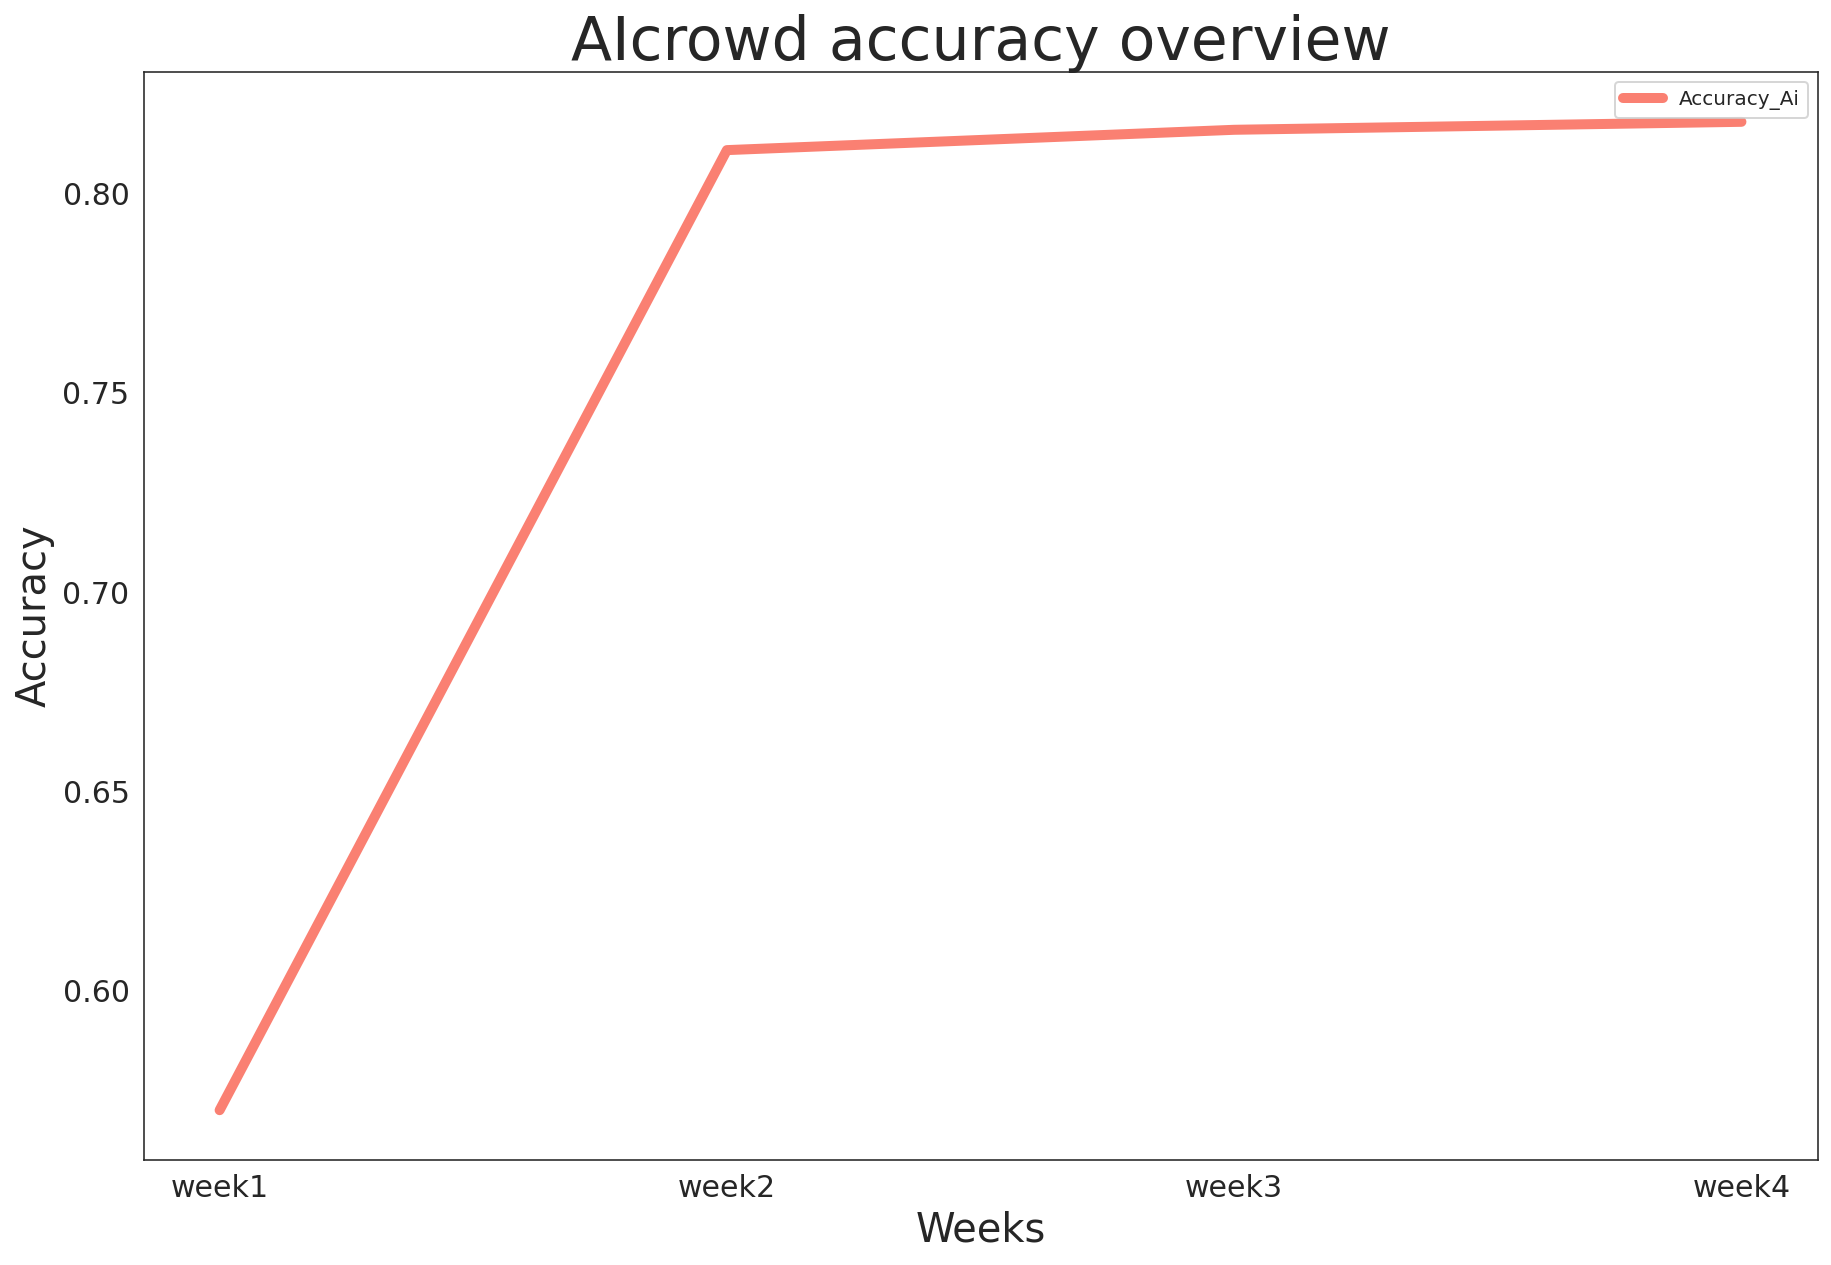

In [ ]:
Accuracy_AICROWD.set_index('week').plot.line(figsize = (15, 10), linewidth = 5, color = 'salmon')
plt.title('AIcrowd accuracy overview', fontsize = 30)
plt.xlabel('Weeks', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

**Accuracy table**

Note: ```GridSearch(cv = 5)``` used for all optimizations

| **Model**                                                | **Parameters**                                                                               |**Internal Accuracy**|
|----------------------------------------------------------|-------------------------------------------------------------------------------------------------------|------------|
| **Logistic regression**                                  |                                                                                                       |            | 
| X = tweet (non-optimized)                                | ```max_iter = 100000```                                                                               | 0.804      |
| X = tweet (hyperparameters optimization)                 | ```C = 3.6, ngram_range = (1,3), norm = 'l1'```                                                       | **0.823**  |
| X = location                                             | ```C = 1```                                                                                           | 0.59       |
| X = lexical categories (all)                             | ```C = 1```                                                                                           | 1          |
| X = lexical categories (reduced)                         | ```C = 2```                                                                                           | 0.676      |
| X = lexical categories (std)                             | ```C = 2```                                                                                           | 0.676      |
| X = lexical categories (std + PCA)                       |                                                                                                       | 0.676      |
| X = keywords                                             | ```C = 1```                                                                                           | 0.59       |
| *Combined features*                                      |                                                                                                       |            |
| X = lexical + location                                   |                                                                                                       | 0.662      |
| X = lexical + keyword                                    |                                                                                                       | 0.654      |
| X = location + keyword                                   |                                                                                                       | 0.579      |
| X = all features                                         |                                                                                                       | 0.654      |
| **KNN**                                                  |                                                                                                       |            |
| X = tweet (non-optimized)                                |                                                                                                       | 0.762      |
| X = tweet (hyperparameters optimization)                 | ```ngram_range = (1,3), norm = 'l2', p = 2, weights = 'distance', n_neighbors = 19, leaf_size = 1```  | **0.779**  |
| X = lexical categories (hyperparameters optimization)    | ```p = 1, weights = 'distance', n_neighbors = 19, leaf_size = 1```                                    | 0.728      |
| **Decision tree**                                        |                                                                                                       |            |
| X = tweet (non-optimized)                                | ```ngram_range = (1,3), norm = 'l2'```                                                                | 0.755      |
| X = tweet (hyperparameters optimization)                 | ```max_depth = 71, min_samples_split = 15```                                                          | **0.762**  |
| **Random forest**                                        |                                                                                                       |            |
| X = tweet (non-optimized)                                | ```ngram_range = (1,3), norm = 'l2'```                                                                | 0.792      |
| X = tweet (hyperparameters optimization)                 | ```criterion = entropy```                                                                             | **0.793**  |
| X = lexical categories (hyperparameters optimization)    | ```bootstrap = true, criterion = gini, 11, n_estimators = 10```                                       | 0.667      |

It seems that the dataset was well fited for logistic regression (we got the best results). 

It seems that our model is good when it is obviously a real. However, it has difficuties to predict fake news. 

We tried to used different extra features such as the lexical categories, the keywords and the location. However, it does not increased our accuracy. 

The next step would be to use these features and combined them directly with the TFIDF. And obviously, use other classifiers or models.

# **The end**


**The Alpina team**  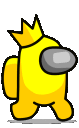